# Cusp Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import pandas as pd
import sidetable
import utils
import StressTools as tools

## Clean up cusp data file

In [2]:
raw = pd.read_csv('cuspData/CuspDataFromKyleMohr.csv')

# Remove extra measurements beyond 2
raw = raw.groupby('Cusp_ID').head(2)

# Remove items that only have 1 angle measurement
freq = raw.stb.freq(['Cusp_ID'])
singles = freq.loc[freq['Count'] < 2]
mask = ~raw.Cusp_ID.isin(singles.Cusp_ID)
cusps = raw[mask].copy()

### Convert latitudes and longitudes

In [3]:
cusps['lon'] = (360 - cusps['Long_dd']) % 360
cusps['lat'] = cusps['Lat_dd']

## Split data into left and right groups

In [4]:
left_cusps = cusps.iloc[::2]
right_cusps = cusps.iloc[1::2]

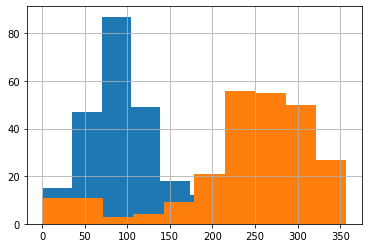

In [5]:
left_cusps.CompassA.hist()
right_cusps.CompassA.hist()

## Get stress field for cusps

In [6]:
interior = interior = utils.import_interior('interior1')

left_coords = left_cusps[['lat', 'lon']]
right_coords = right_cusps[['lat', 'lon']]

left_stress = tools.get_simon_stress_field(interior, left_coords, 0, 0.01, 0, 0)
right_stress = tools.get_simon_stress_field(interior, right_coords, 0, 0.01, 0, 0)

## Match Angles to stresses

In [7]:
from io import BytesIO
import base64

def figureToInlineImage(figure):
    file = BytesIO()
    figure.savefig(file, format='png')
    file.seek(0)
    
    png_data = base64.b64encode(file.getvalue()).decode()
    image_str = f'<img width="200" height="100" src="data:image/png;base64,{png_data}" />'
    
    return image_str

def match_angles(points, stresses, name, show_plots=True):
    results = []
    
    for point in points.itertuples():
        stress_data = stresses.loc[(stresses.lon == point.lon) & (stresses.lat == point.lat)]
        
        sorted_stress = stress_data.copy().sort_values('heading')
        angle = point.CompassA if point.CompassA >= 180 else (180 + point.CompassA) % 360

        spline = InterpolatedUnivariateSpline(sorted_stress.heading, sorted_stress.stress)
        slopes = spline.derivative()
        
        matched_stress = spline(angle)
        slope = slopes(angle)
        is_increasing = slope > 0
        max_stress = stress_data.stress.max()
        min_stress = stress_data.stress.min()
        
        sample_points = np.linspace(180, 360, 720)
        slope_list = slopes(sample_points)
        max_slope = slope_list.max()
        min_slope = slope_list.min()
        positive_slopes = slope_list[slope_list > 0]
        median_slope = np.median(positive_slopes)
        slope_ratio = slope / max_slope
        median_ratio = slope / median_slope

        image = ''
        if show_plots:
            fig, ax = plt.subplots(figsize=(4,2))
            
            ax.title.set_text(f'{name} - lat: {point.lat}, lon: {point.lon}')
            ax.vlines(angle, ymin=min_stress, ymax=max_stress, colors=['red'], linestyles='dashed')
            ax.hlines(matched_stress, xmin=175, xmax=360, colors=['red'], linestyles='dashed')

            spx = np.linspace(180, 360, 360)
            ax.plot(spx, spline(spx))
            image = figureToInlineImage(fig)
            plt.show()

        
        results.append(dict(lat=point.lat,
                            lon=point.lon,
                            Id=point.Id,
                            cycloid_number=point.Cycloid_Nu,
                            cusp_id=point.Cusp_ID,
                            orientation_original=point.CompassA,
                            orientation_translated=angle,
                            stress=matched_stress, 
                            max_stress=max_stress, 
                            slope=slope,
                            is_increasing=is_increasing,
                            max_slope=max_slope,
                            min_slope=min_slope,
                            median_positive_slope=median_slope,
                            slope_to_max=slope_ratio,
                            slope_to_median_positive=median_ratio,
                            stress_plot=image))
        
    return pd.DataFrame(results)

In [8]:
left_points = left_cusps #.loc[left_cusps.Cycloid_Nu == 13]
right_points = right_cusps #.loc[right_cusps.Cycloid_Nu == 13]


left_matched = match_angles(left_points, left_stress, 'Left Side', show_plots=False)
right_matched = match_angles(right_points, right_stress, 'Right Side', show_plots=False)
left_matched['cusp_direction'] = 'left'
right_matched['cusp_direction'] = 'right'

## Output Unified Dataset

In [9]:
all_matches = pd.concat([left_matched, right_matched])
all_matches.to_csv('./output/leftRight/interpolatedStress.csv.gz', compression='gzip', index=False)

In [10]:
all_matches

lat      lon  Id  cycloid_number  cusp_id  orientation_original  \
0    45.386  351.386   1               1        1            113.869807   
1    45.428  351.301   2               1        2             62.732584   
2    41.650  354.153   1               2        4            127.002526   
3    35.020  349.844   1               3        6            147.763213   
4    48.648  333.050   1               4        7            138.447387   
..      ...      ...  ..             ...      ...                   ...   
242  70.033  229.342   2              86      248             65.772255   
243  68.522  230.068   3              86      249             33.996459   
244  63.367  231.136   4              86      250             19.573126   
245  34.203  281.789   1              87      251            355.333142   
246  35.013  301.552   1              88      252            320.389312   

     orientation_translated              stress  max_stress  \
0                293.869807   43.27142005037422   61.556707   
1                242.732584  60.804832949525924   61.642512   
2                307.002526  49.265915744657434   59.307134   
3                327.763213  19.666718626427674   66.481551   
4                318.447387  32.407573940054476   79.193210   
..                      ...                 ...         ...   
242              245.772255   37.07854952657697   86.899874   
243              213.996459   16.71887396643373   87.094543   
244              199.573126   20.92548338812582   87.915685   
245              355.333142  14.873574153870385   91.273007   
246              320.389312   42.86701079594218   98.345536   

                     slope  is_increasing  max_slope  min_slope  \
0      0.07254081701627643           True   1.953895  -1.504548   
1      -0.4286333461208638          False   1.950668  -1.496832   
2    -0.024475777143790536          False   2.398455  -2.100890   
3       -3.163102315836595          False   3.670793  -3.163649   
4     -0.12783743481688215          False   1.808680  -1.306966   
..                     ...            ...        ...        ...   
242     1.4737192671244532           True   1.887351  -1.541078   
243   -0.06065726778247341          False   1.876476  -1.475697   
244    -0.5612555151398035          False   1.832858  -1.218368   
245    -0.4999413701709356          False   1.733863  -1.414327   
246     -0.839504196695494          False   2.637943  -1.548185   

     median_positive_slope  slope_to_max  slope_to_median_positive  \
0                 0.443945      0.037126                  0.163400   
1                 0.444851     -0.219737                 -0.963544   
2                 0.466204     -0.010205                 -0.052500   
3                 0.980537     -0.861695                 -3.225889   
4                 0.848125     -0.070680                 -0.150729   
..                     ...           ...                       ...   
242               1.051781      0.780840                  1.401165   
243               1.048482     -0.032325                 -0.057852   
244               1.040494     -0.306219                 -0.539412   
245               0.951282     -0.288340                 -0.525545   
246               1.143854     -0.318242                 -0.733926   

    stress_plot cusp_direction  
0                         left  
1                         left  
2                         left  
3                         left  
4                         left  
..          ...            ...  
242                      right  
243                      right  
244                      right  
245                      right  
246                      right  

[494 rows x 18 columns]

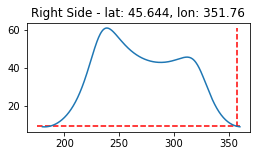

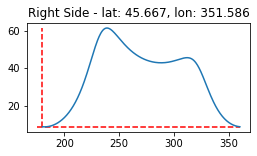

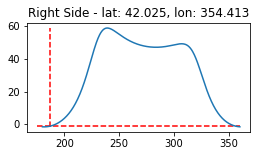

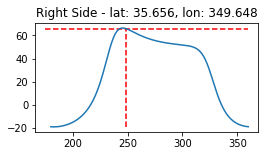

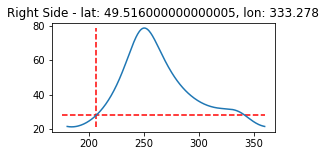

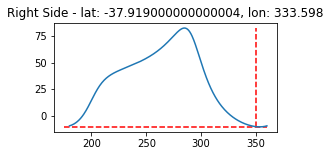

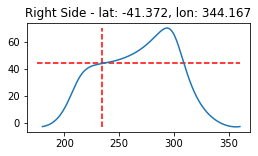

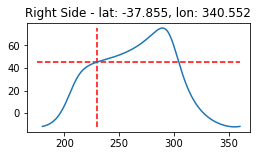

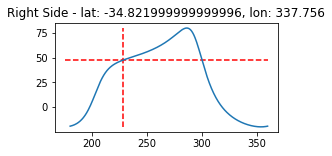

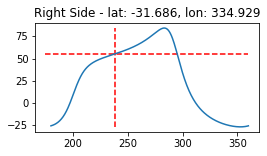

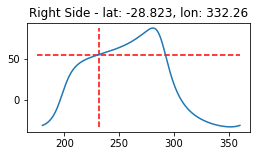

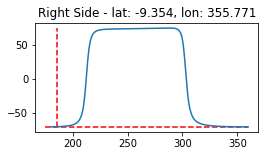

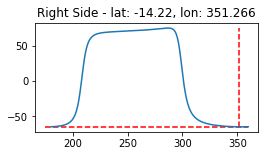

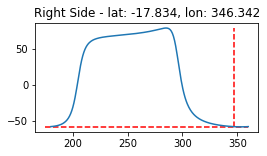

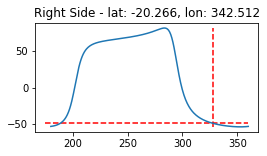

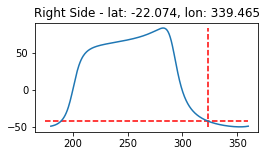

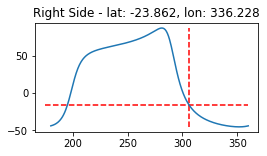

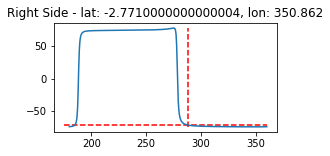

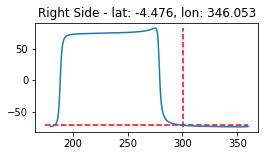

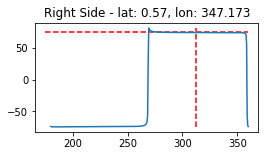

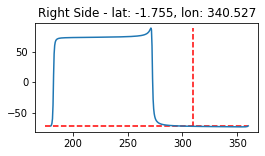

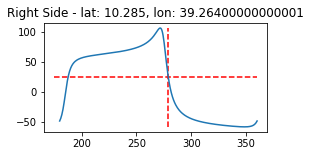

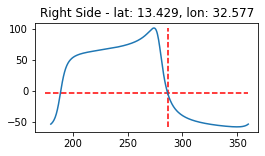

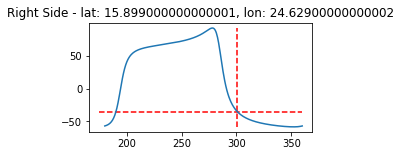

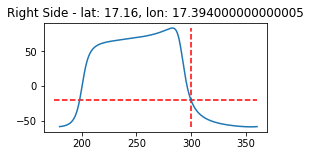

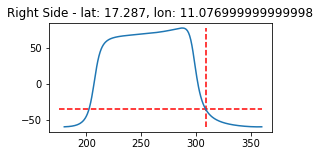

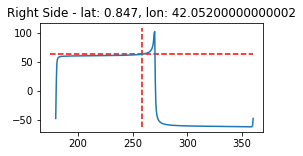

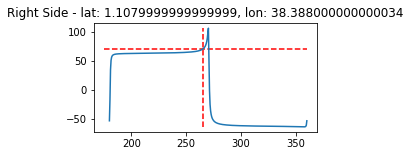

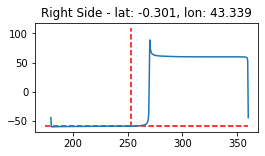

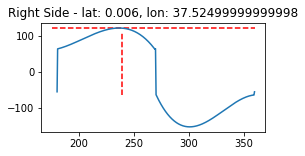

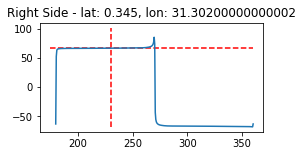

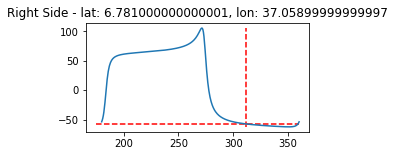

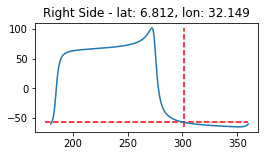

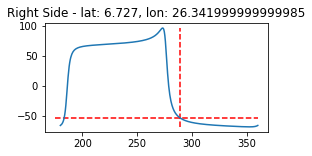

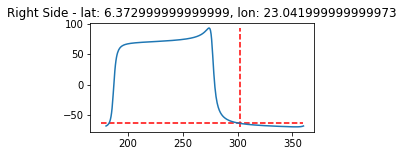

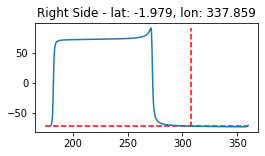

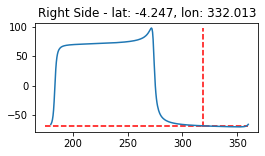

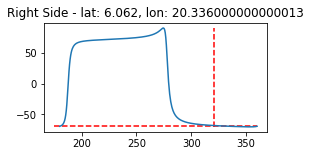

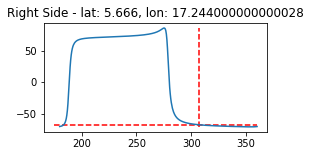

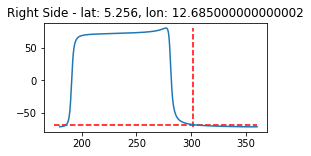

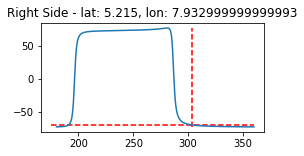

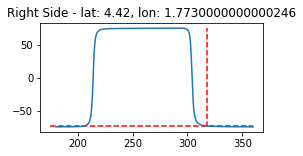

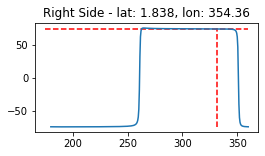

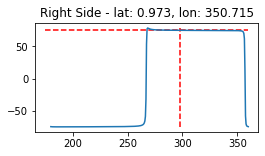

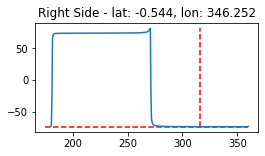

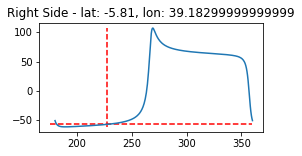

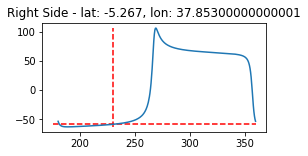

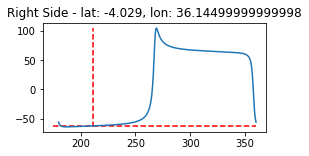

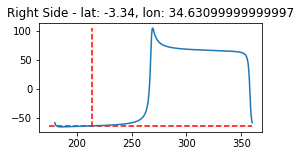

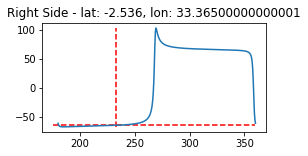

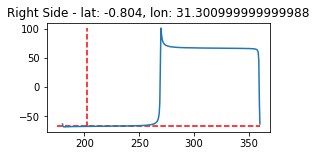

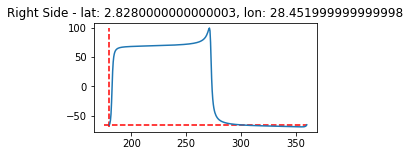

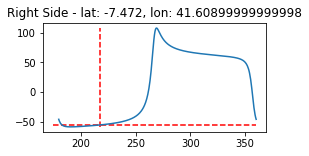

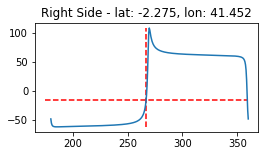

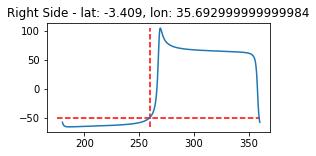

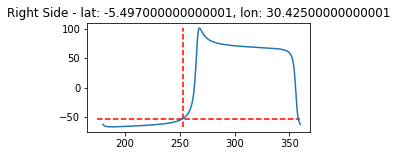

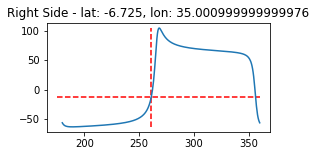

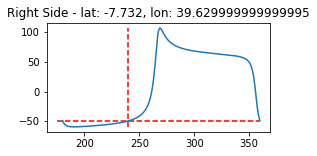

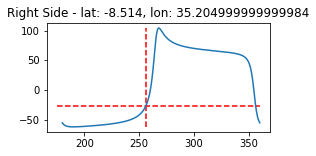

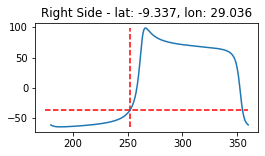

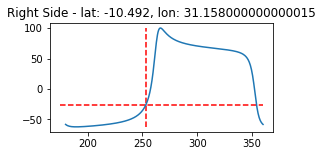

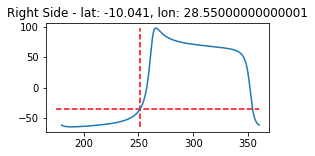

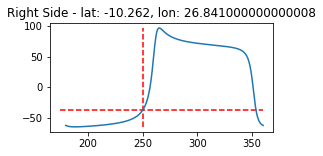

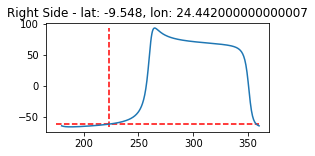

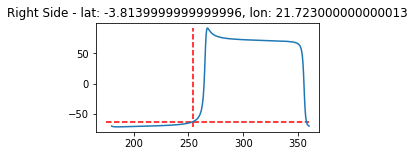

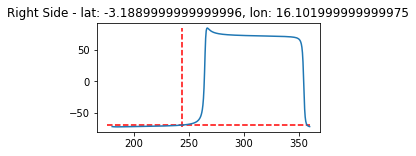

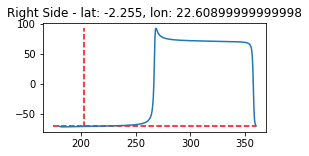

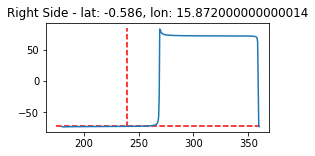

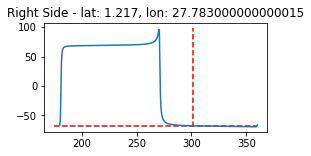

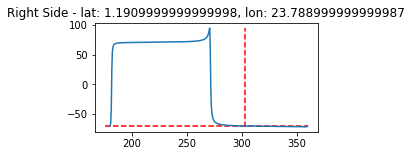

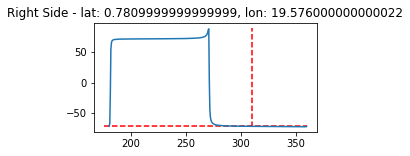

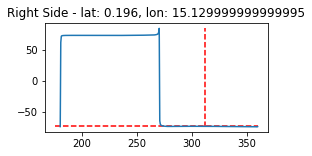

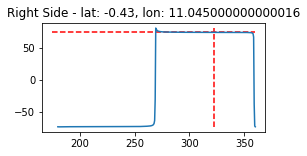

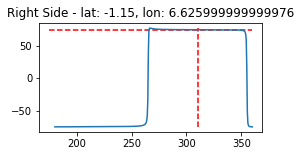

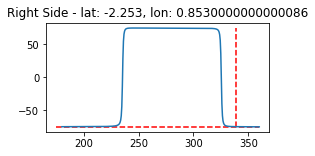

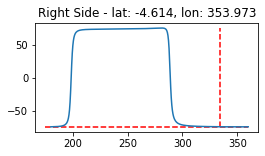

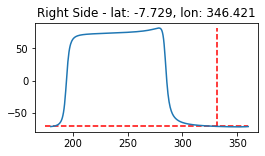

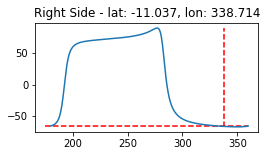

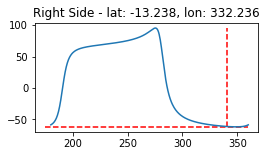

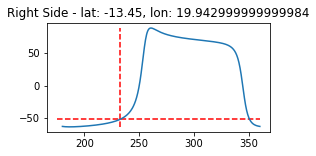

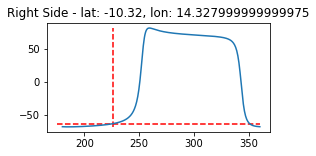

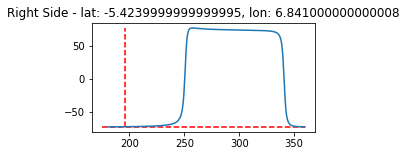

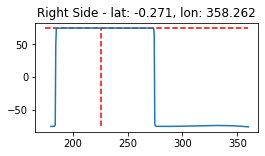

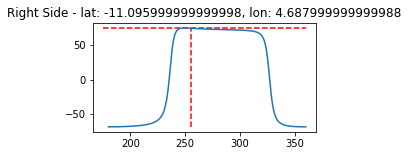

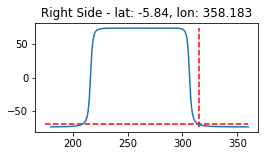

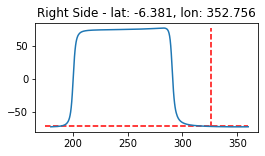

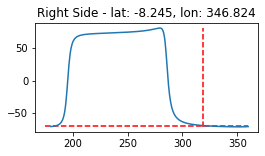

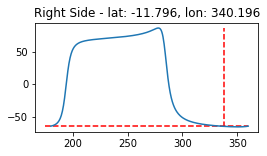

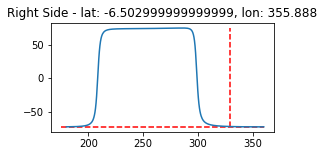

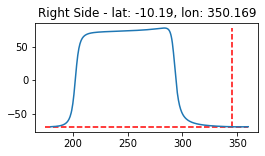

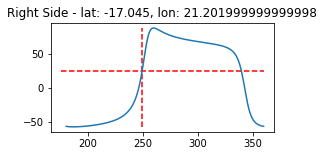

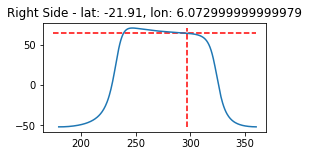

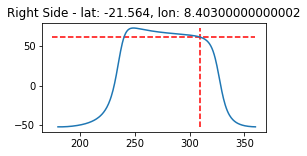

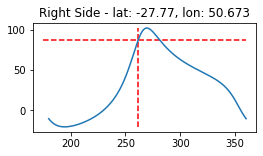

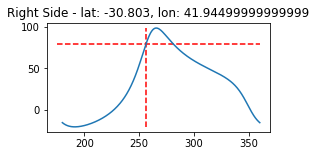

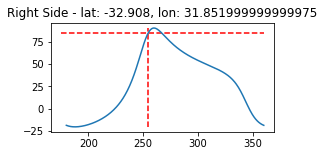

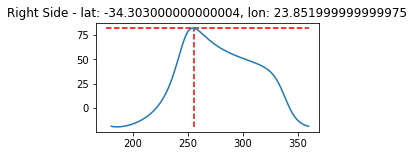

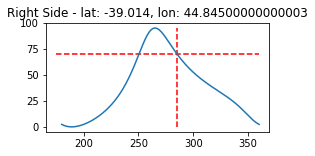

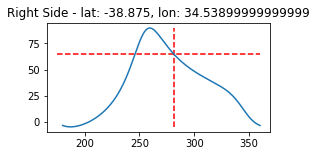

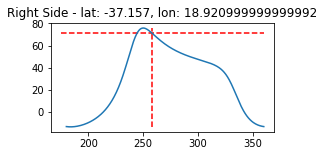

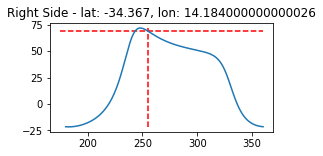

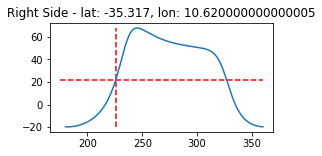

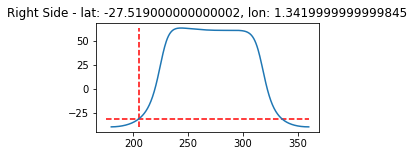

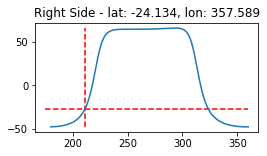

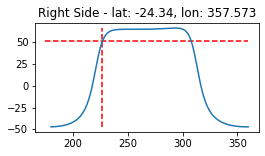

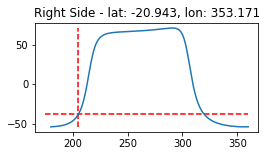

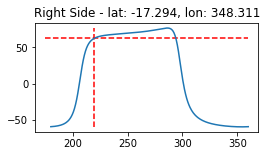

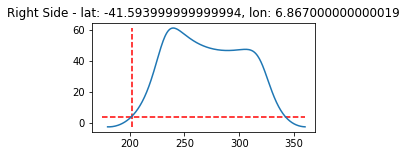

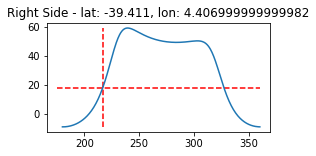

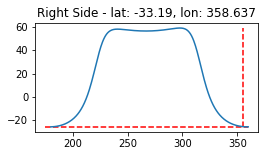

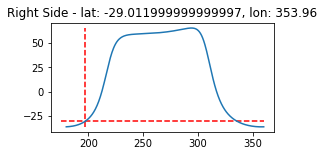

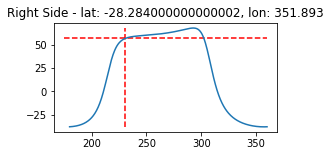

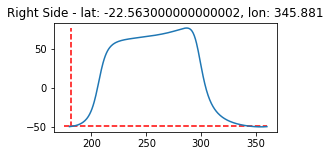

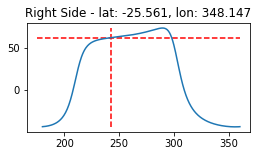

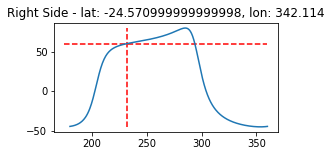

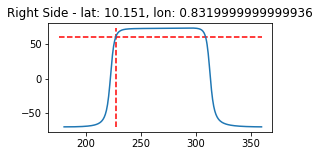

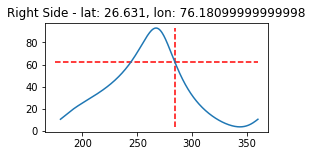

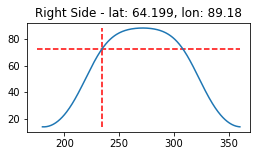

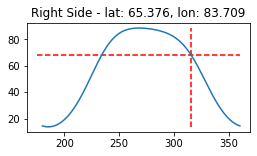

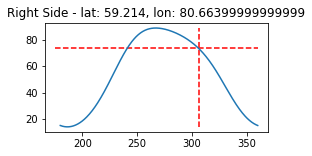

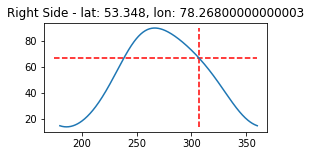

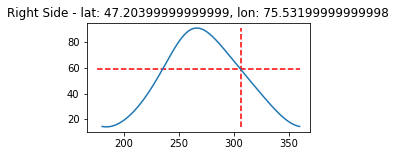

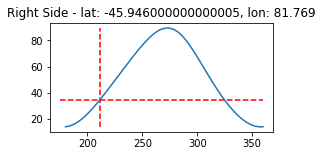

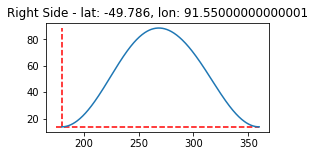

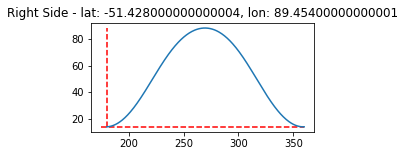

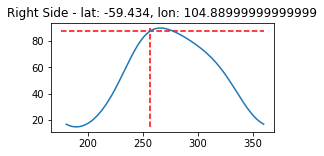

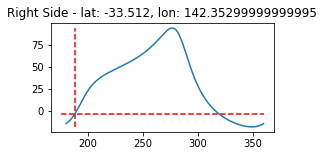

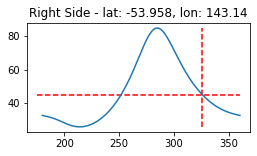

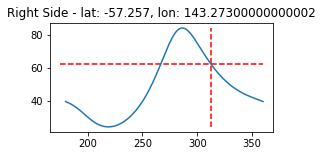

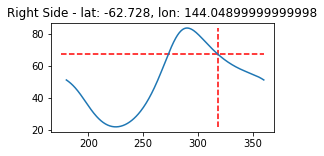

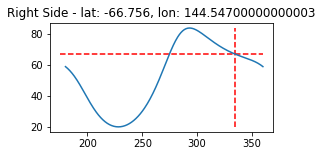

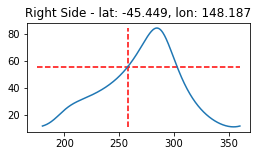

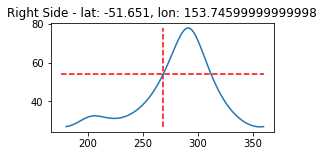

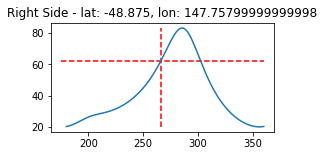

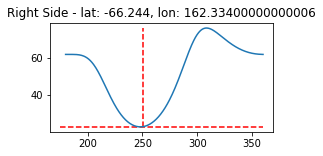

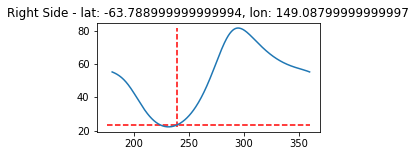

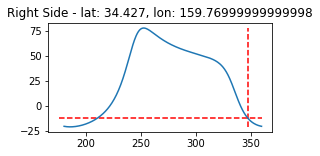

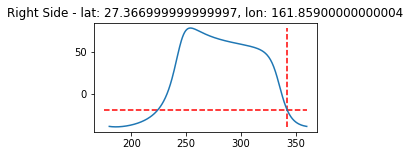

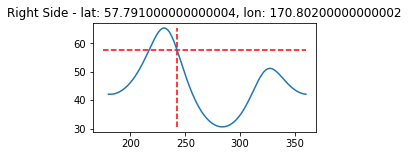

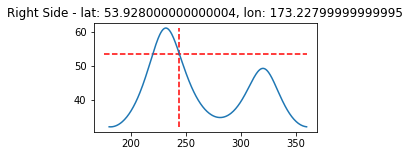

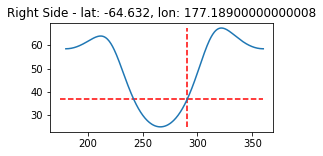

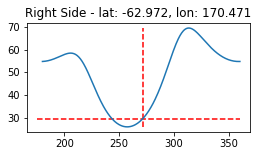

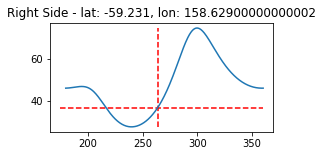

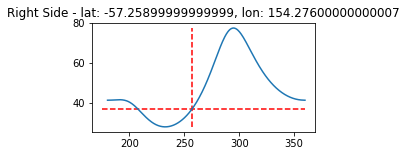

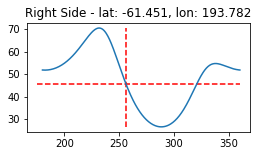

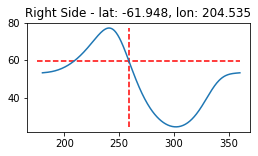

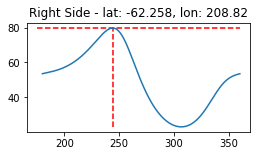

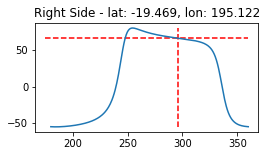

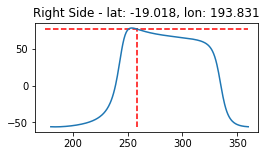

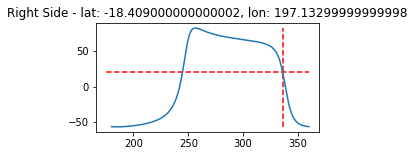

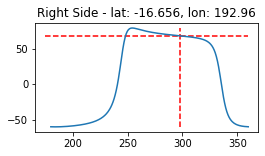

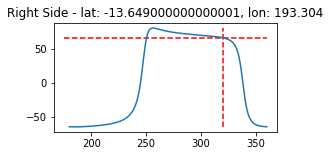

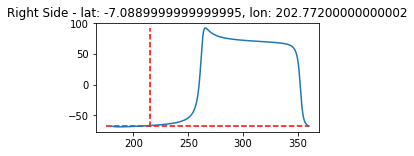

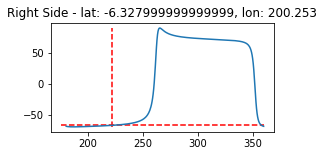

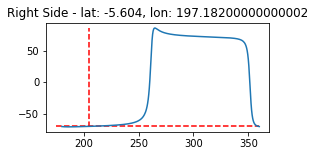

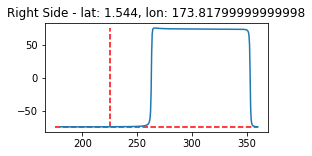

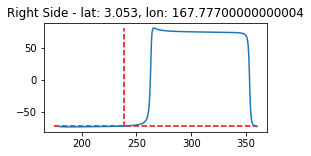

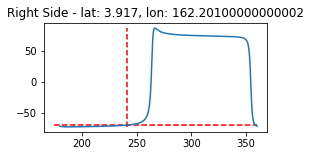

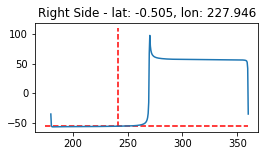

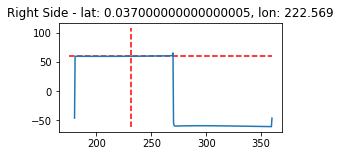

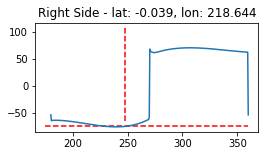

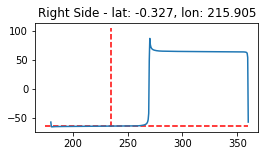

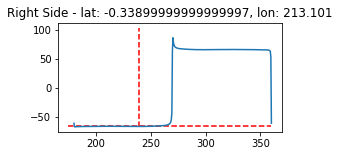

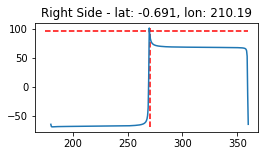

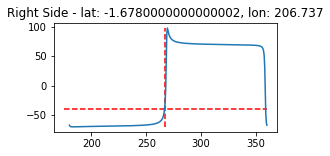

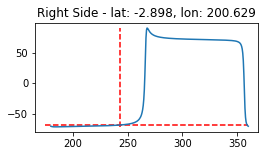

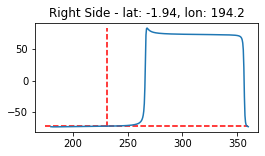

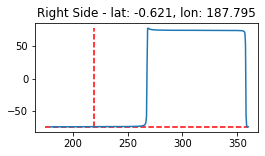

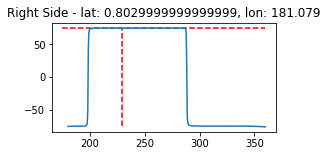

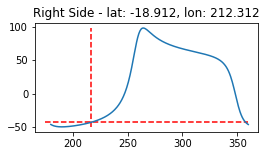

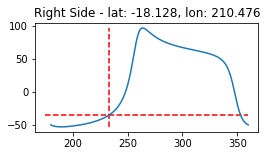

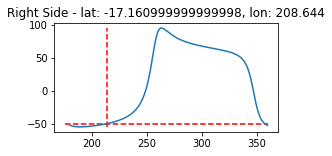

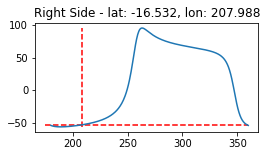

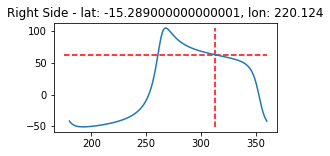

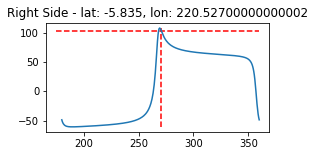

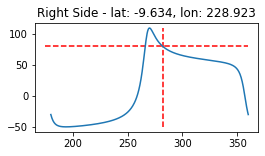

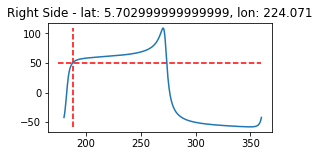

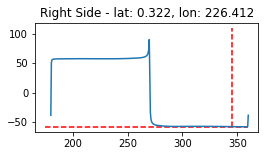

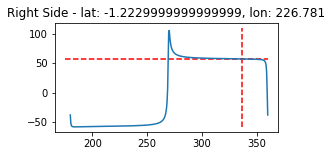

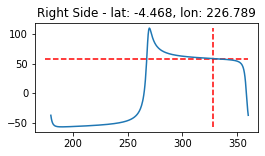

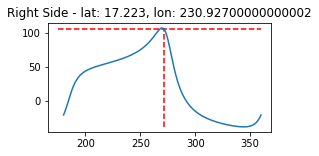

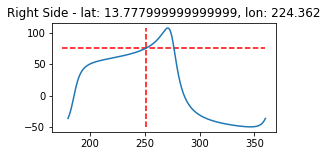

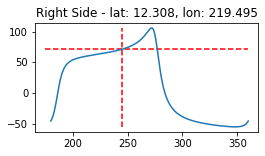

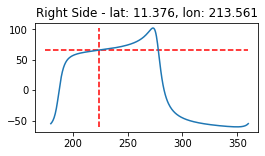

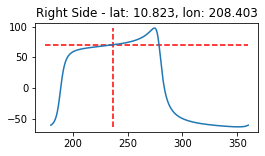

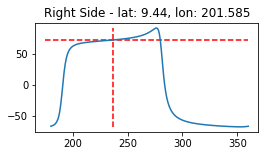

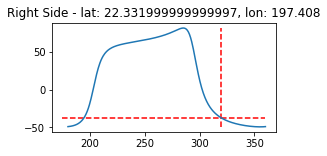

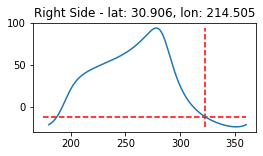

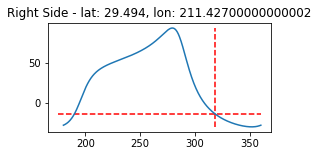

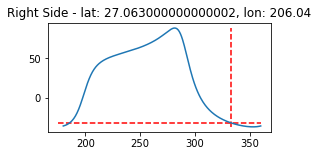

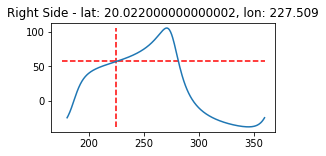

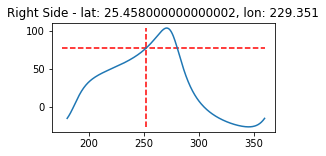

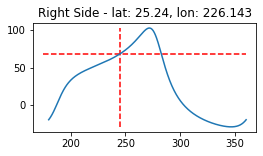

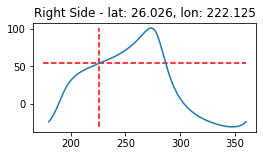

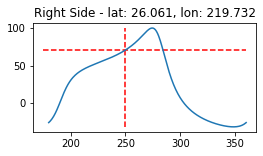

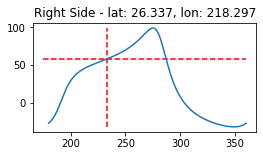

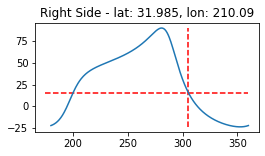

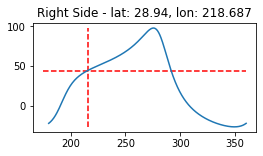

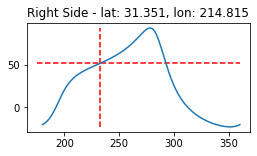

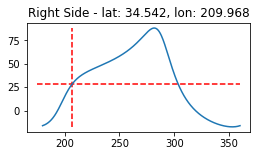

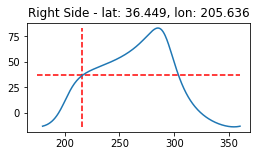

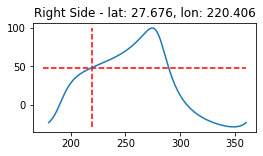

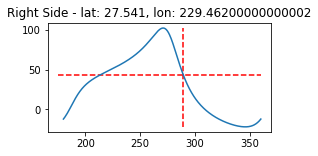

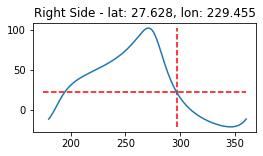

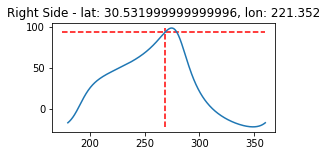

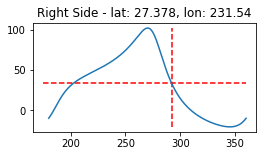

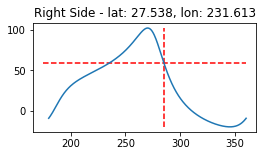

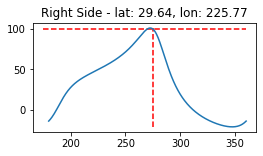

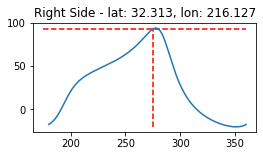

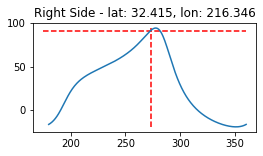

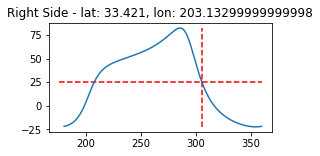

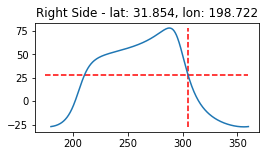

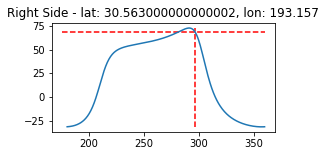

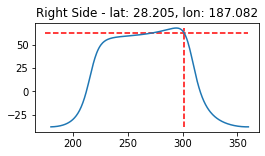

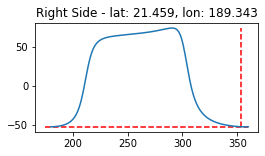

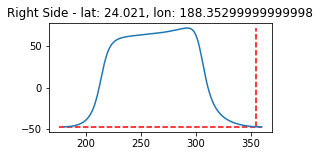

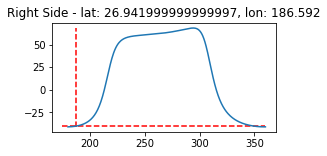

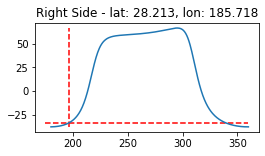

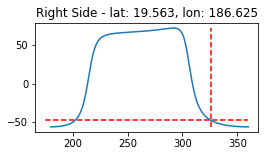

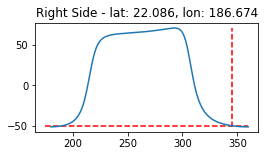

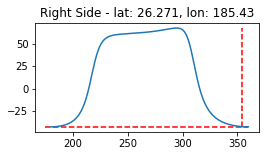

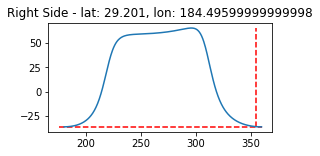

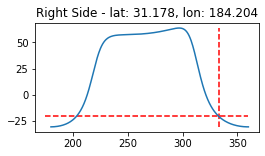

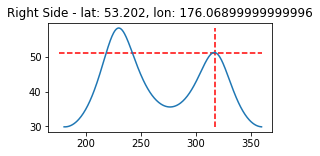

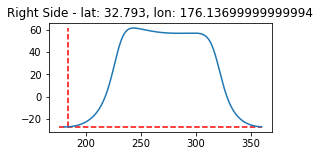

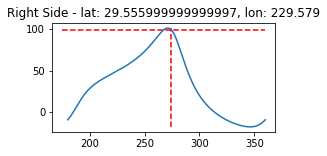

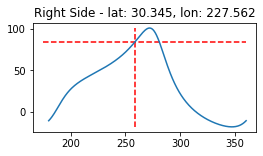

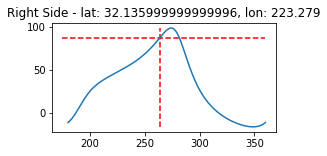

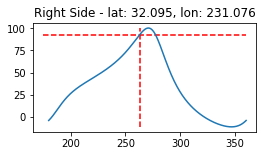

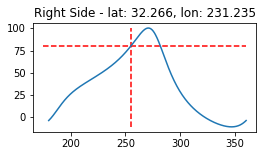

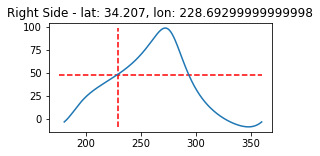

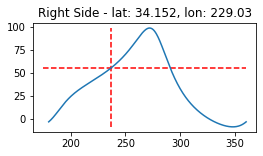

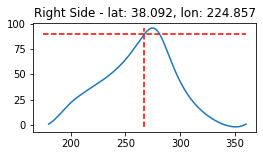

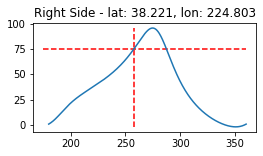

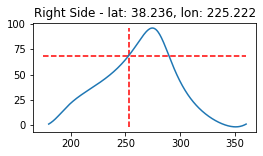

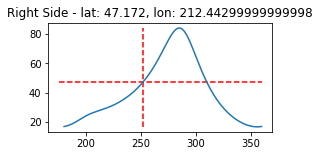

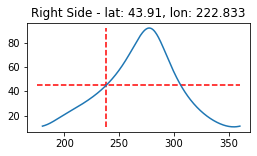

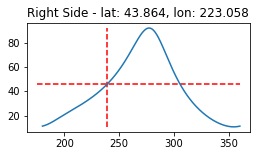

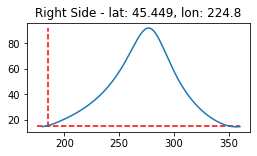

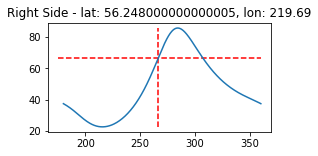

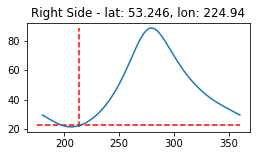

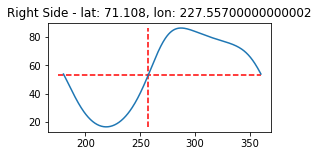

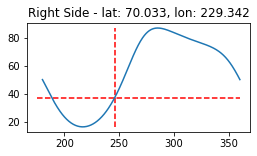

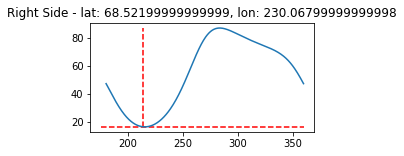

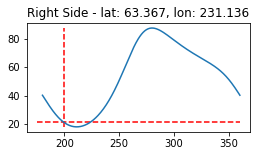

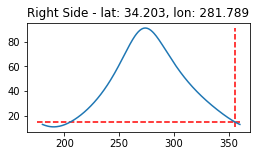

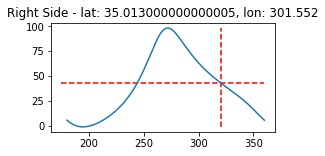

In [11]:
# left_points = left_cusps.loc[left_cusps.Cycloid_Nu == 13]
right_points = right_cusps #.loc[right_cusps.Cycloid_Nu == 14]


# left_matched = match_angles(left_points, left_stress, 'Left Side', show_plots=True)
right_matched = match_angles(right_points, right_stress, 'Right Side', show_plots=True)
# left_matched['cusp_direction'] = 'left'
# right_matched['cusp_direction'] = 'right'


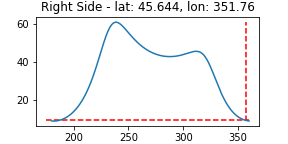
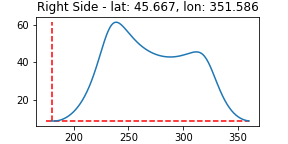
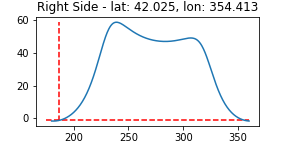
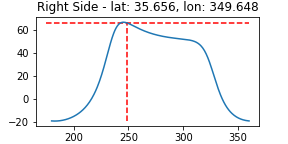
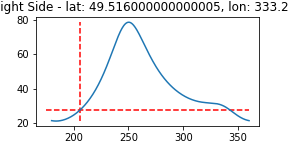
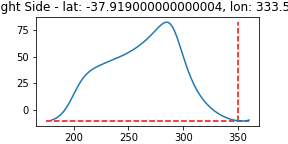
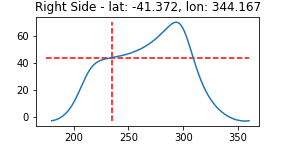
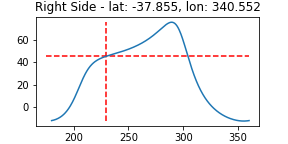
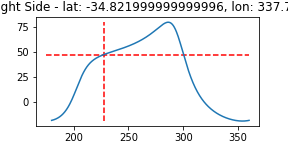
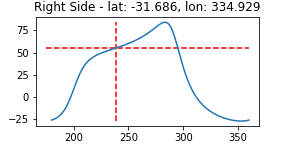
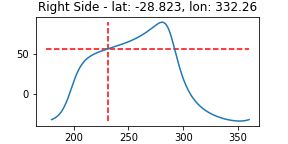
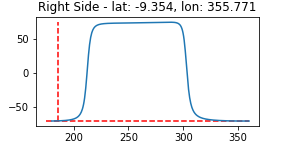
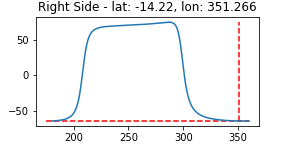
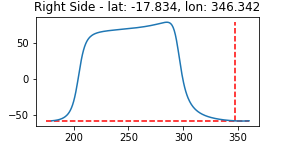
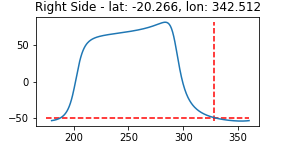
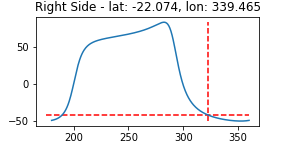
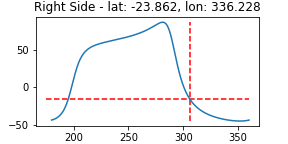
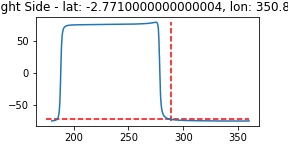
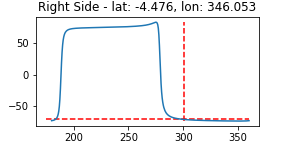
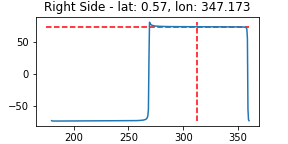
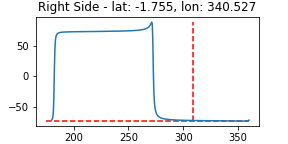
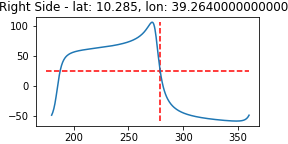
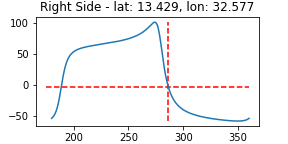
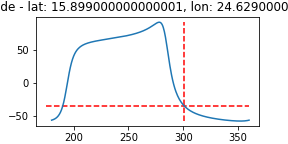
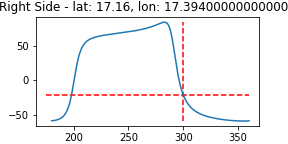
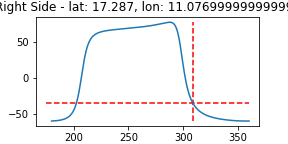
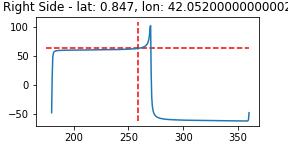
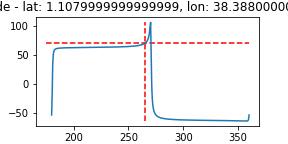
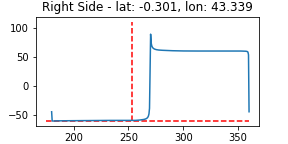
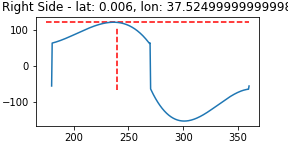
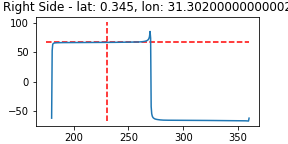
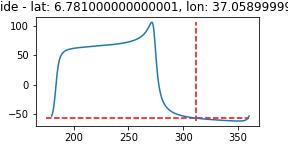
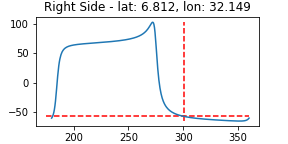
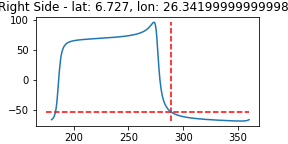
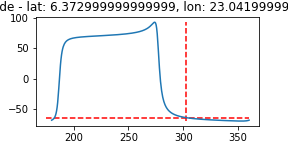
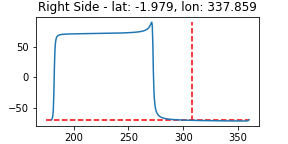
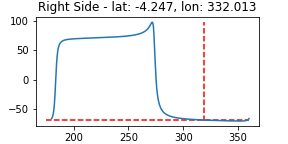
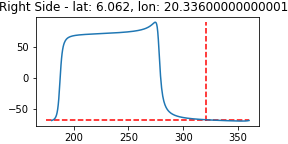
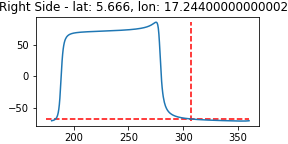
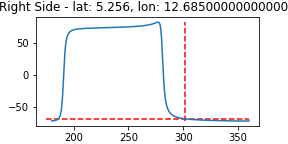
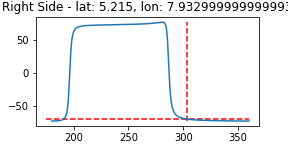
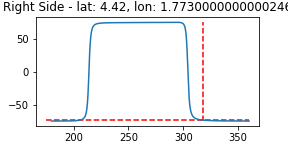
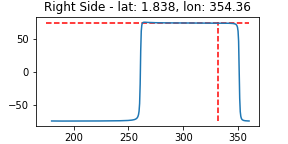
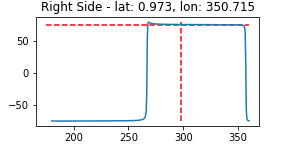
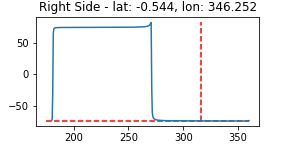
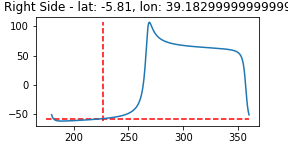
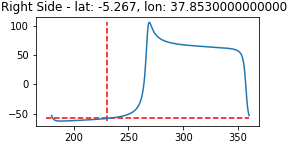
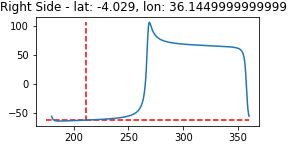
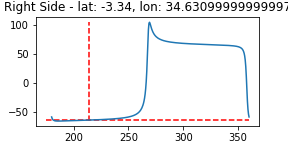
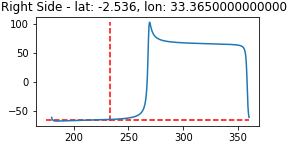
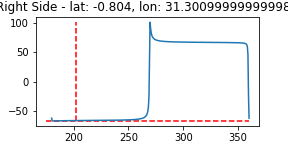
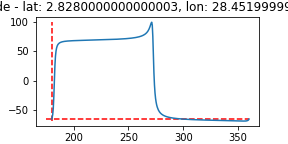
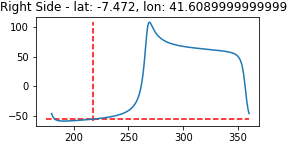
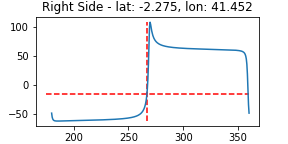
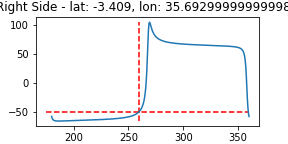
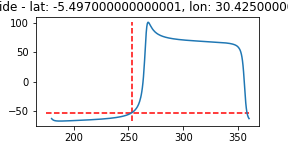
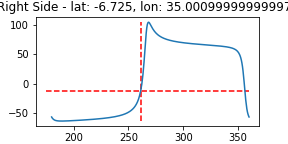
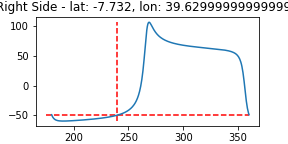
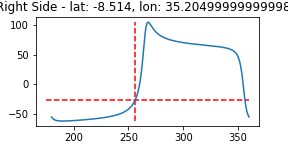
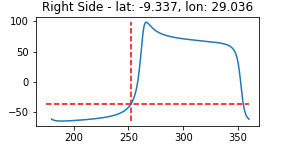
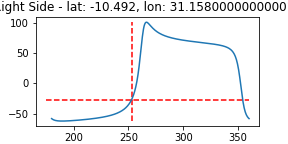
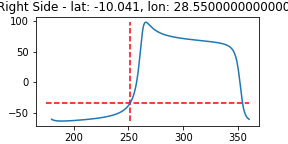
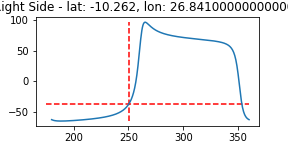
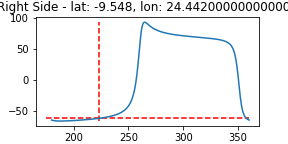
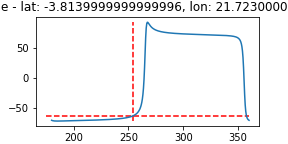
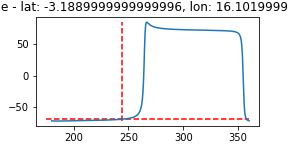
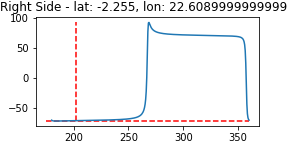
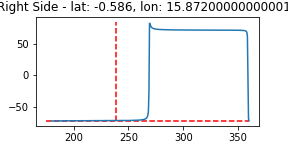
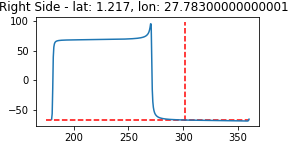
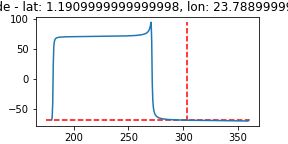
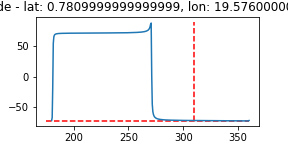
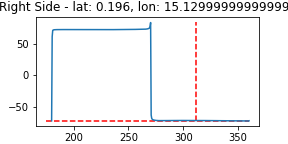
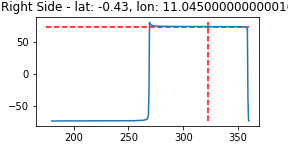
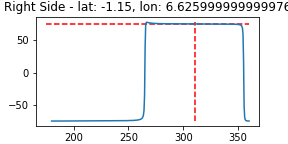
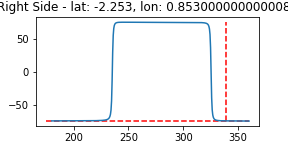
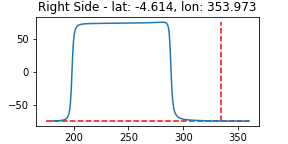
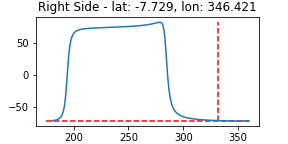
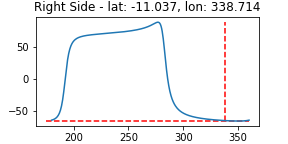
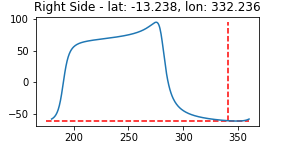
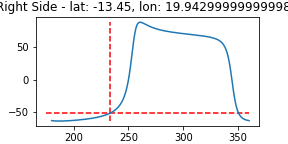
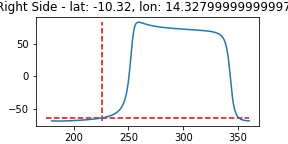
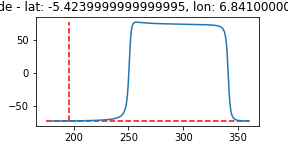
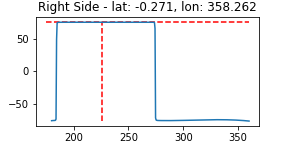
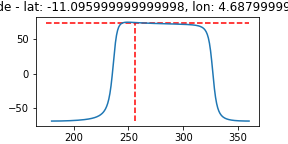
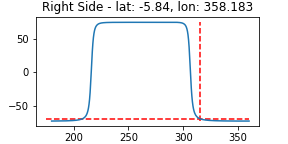
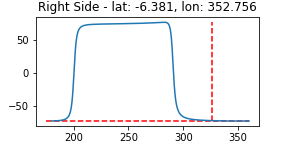
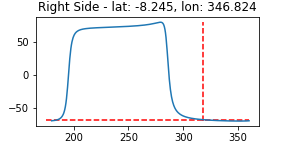
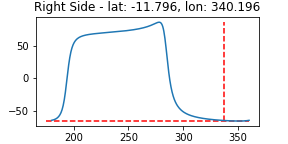
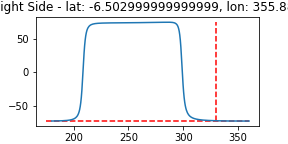
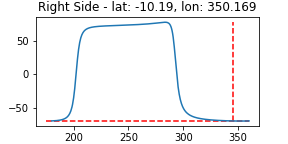
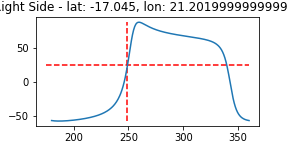
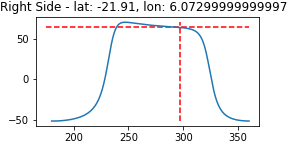
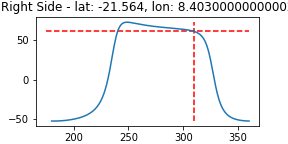
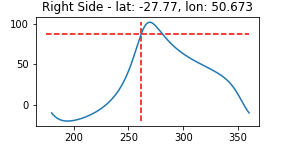
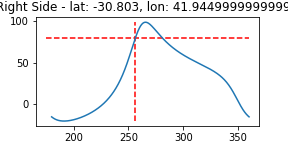
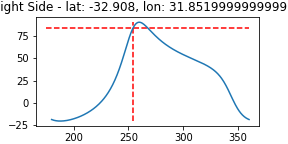
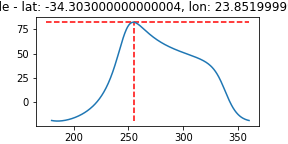
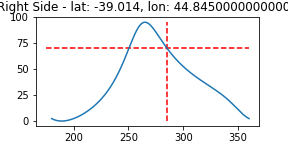
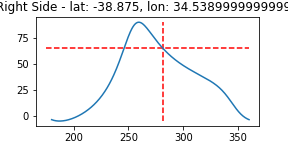
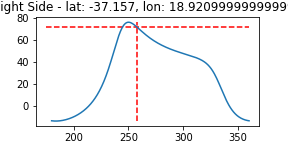
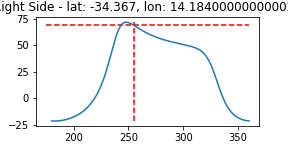
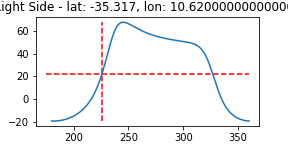
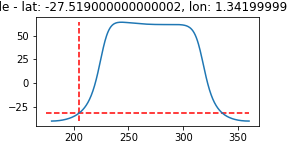
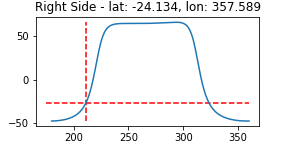
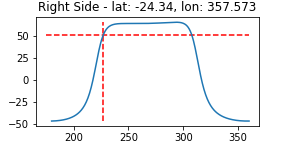
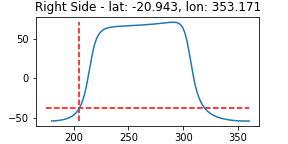
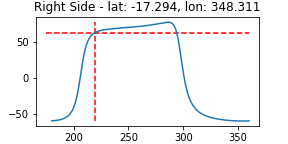
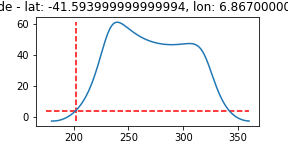
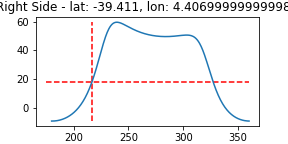
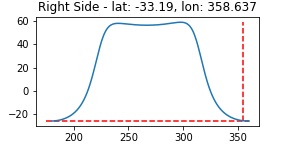
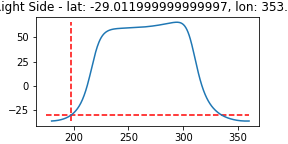
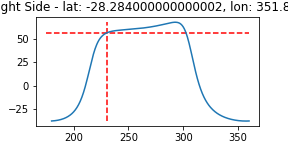
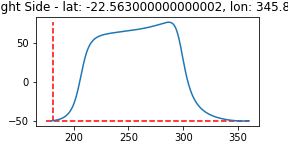
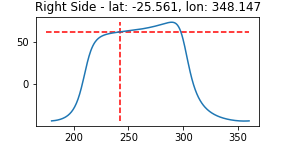
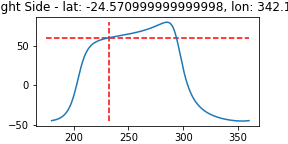
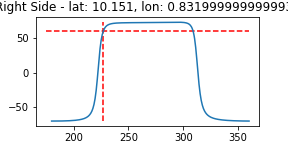
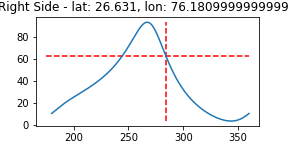
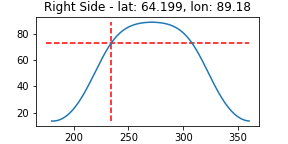
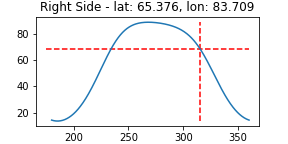
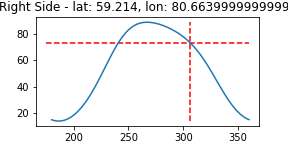
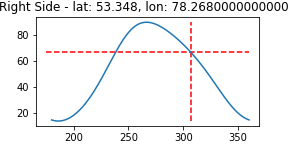
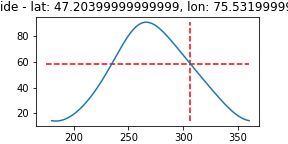
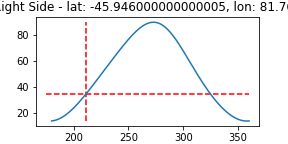
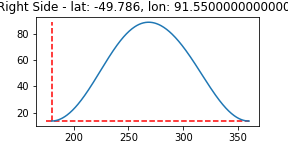
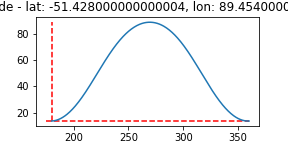
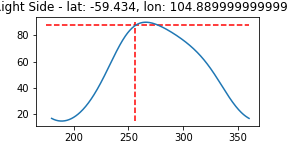
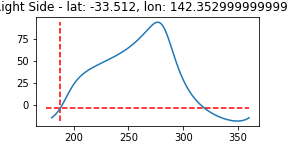
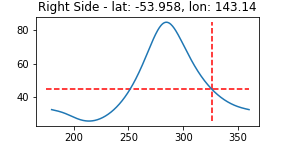
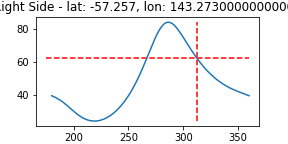
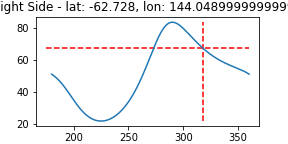
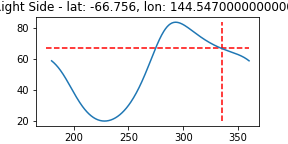
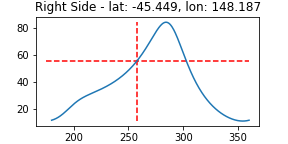
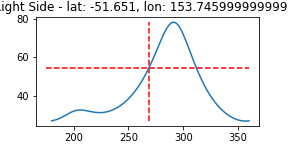
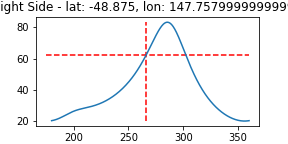
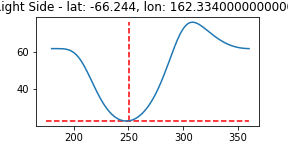
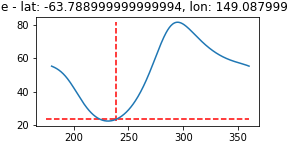
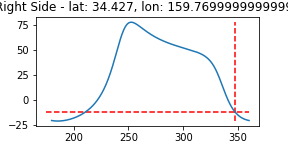
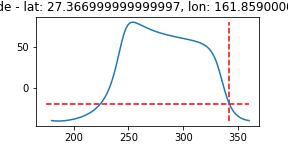
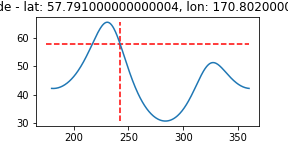
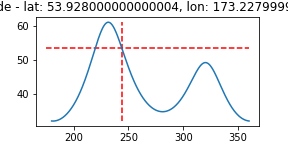
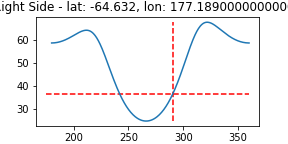
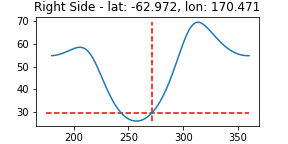
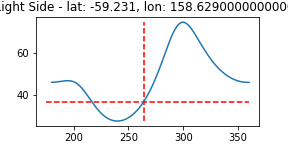
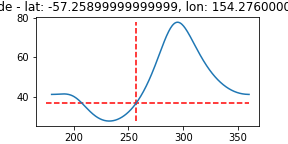
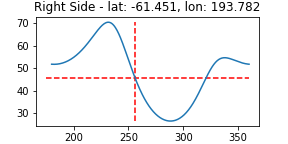
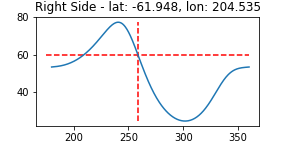
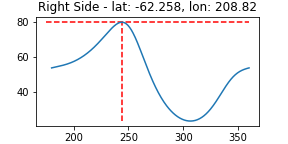
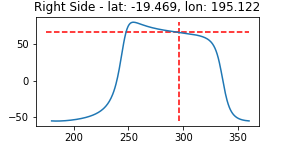
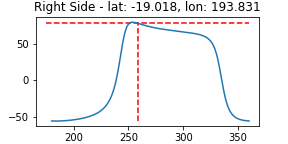
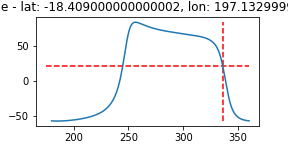
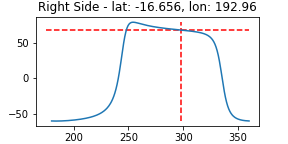
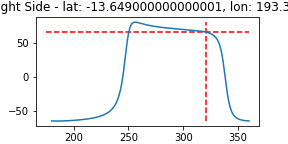
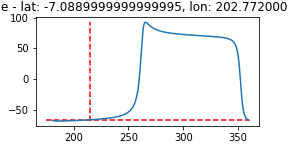
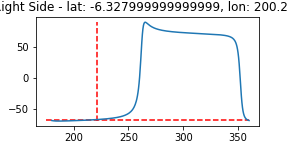
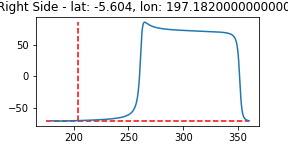
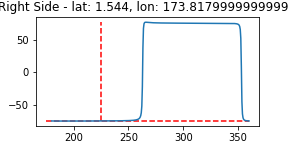
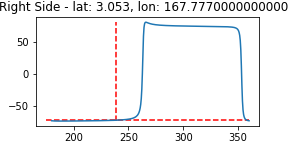
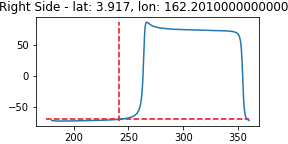
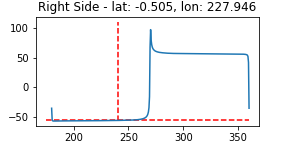
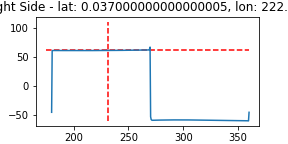
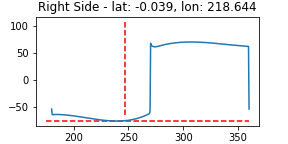
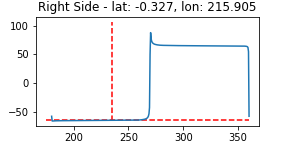
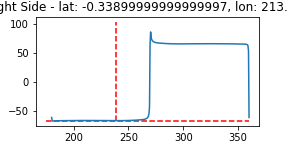
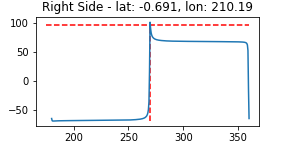
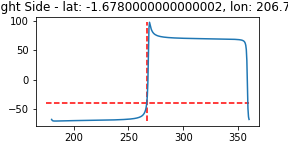
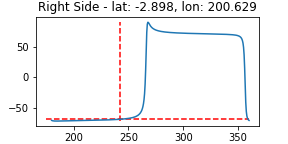
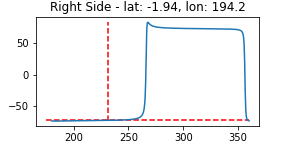
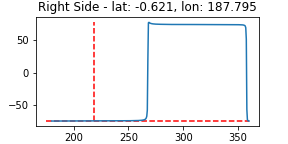
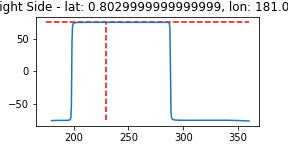
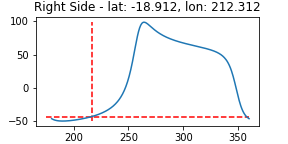
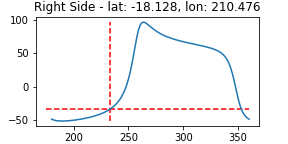
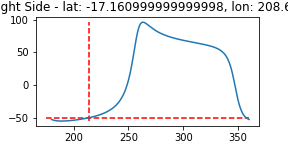
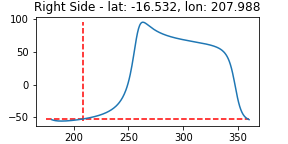
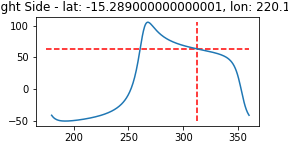
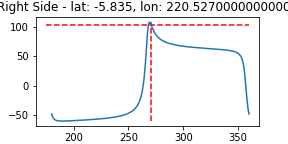
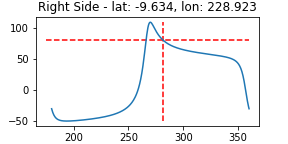
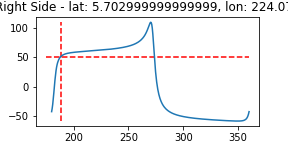
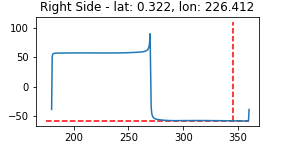
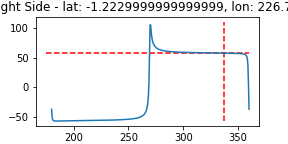
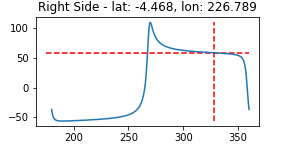
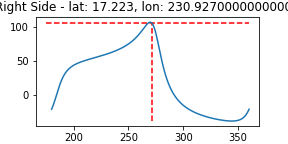
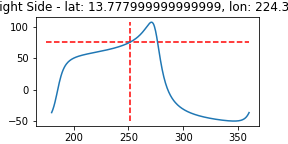
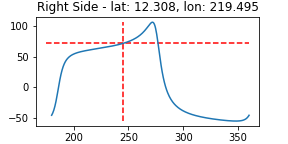
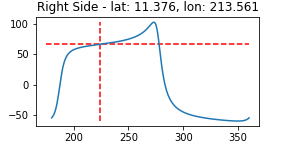
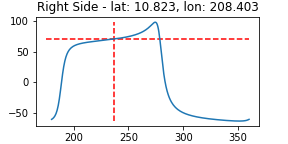
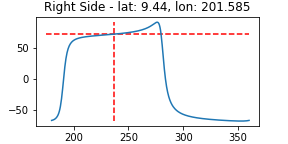
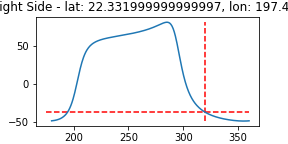
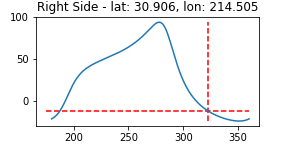
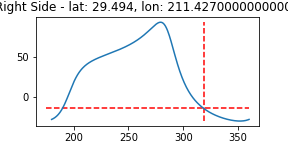
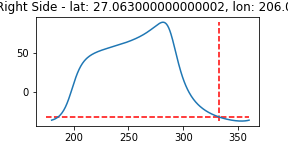
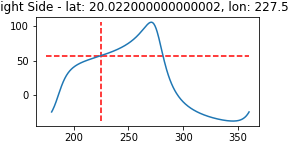
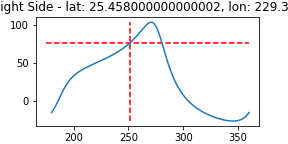
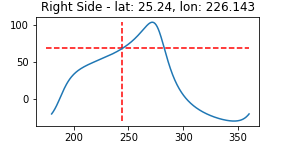
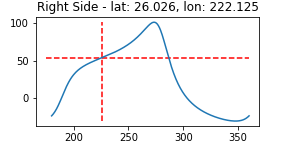
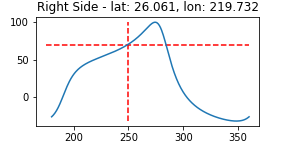
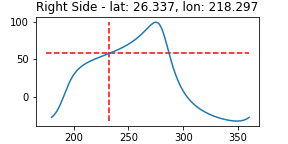
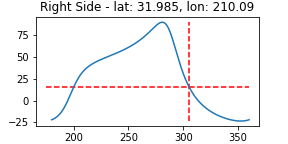
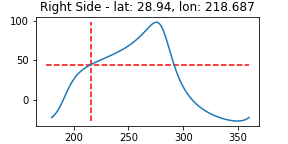
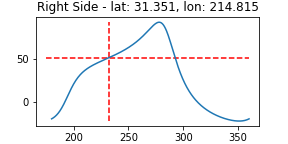
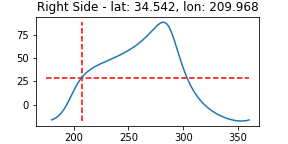
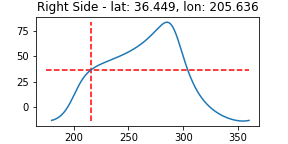
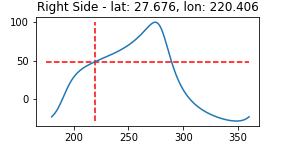
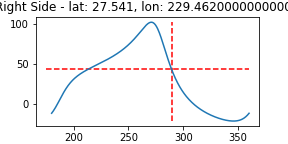
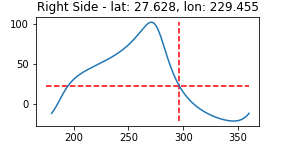
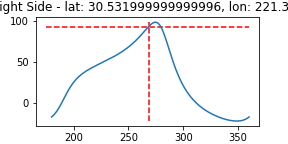
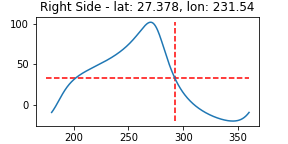
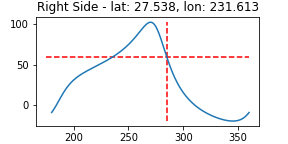
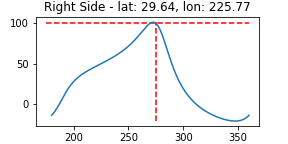
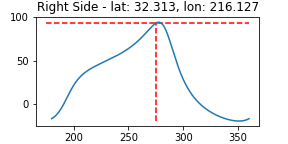
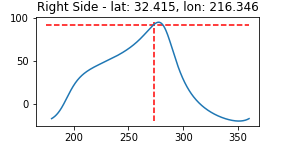
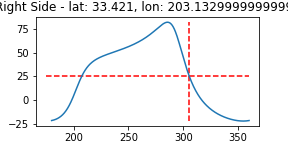
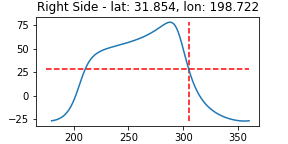
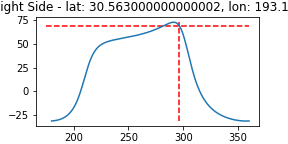
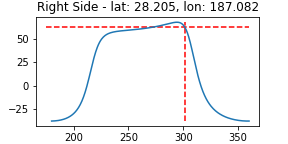
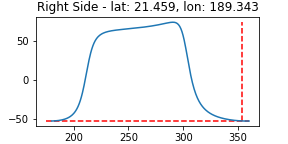
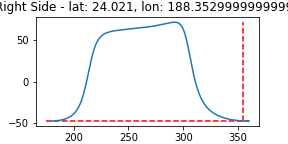
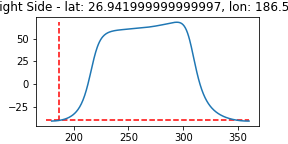
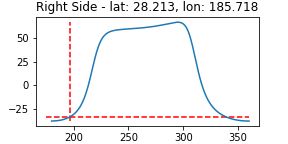
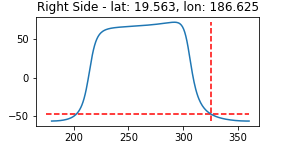
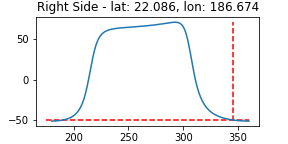
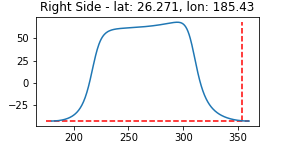
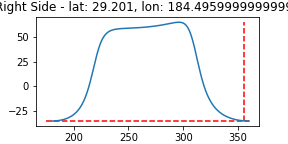
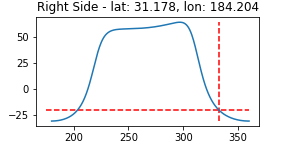
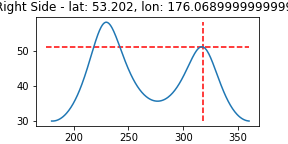
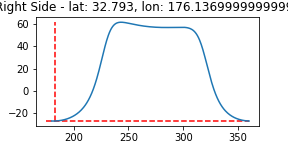
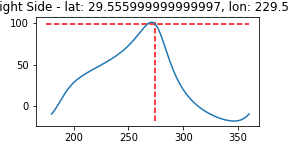
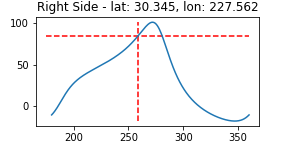
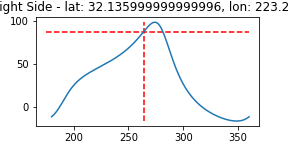
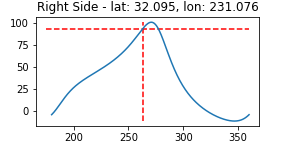
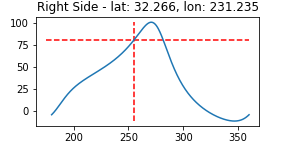
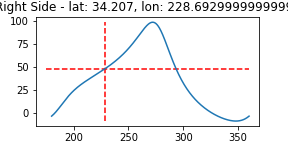
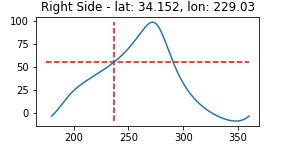
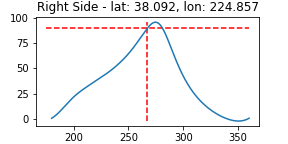
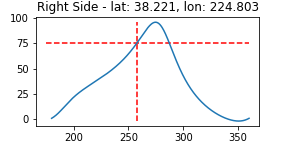
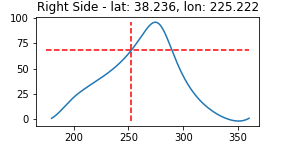
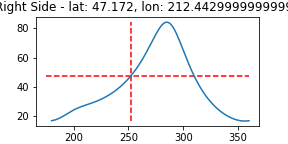
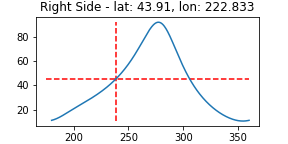
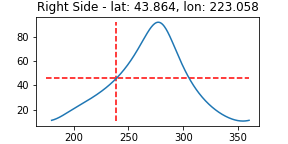
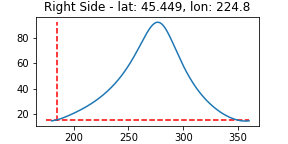
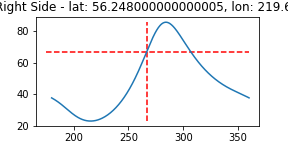
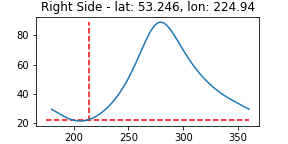
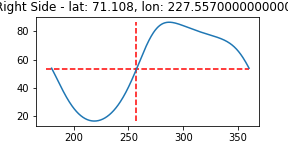
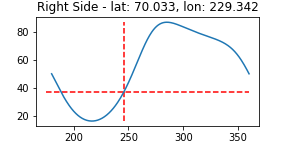
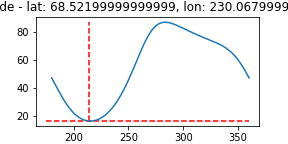
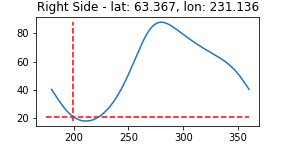
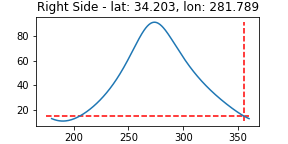
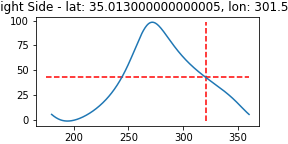

In [12]:
from IPython.display import HTML

pd.set_option('display.max_colwidth', None)


HTML(right_matched[['cycloid_number', 'Id', 'stress', 'max_stress', 'orientation_original', 'orientation_translated', 'stress_plot']].to_html(escape=False))
# left_matched


In [13]:
all_matches.loc[(all_matches.cycloid_number == 14)]

lat     lon  Id  cycloid_number  cusp_id  orientation_original  \
45 -5.737  38.994   1              14       48             85.426079   
46 -5.218  37.693   2              14       49            108.434949   
47 -3.908  35.912   3              14       50             91.789911   
48 -3.184  34.406   4              14       51             72.801459   
49 -2.474  33.161   5              14       52             98.130102   
50 -0.585  30.996   6              14       53             84.400661   
51  3.185  28.146   7              14       54             66.279604   
45 -5.810  39.183   1              14       48            227.121096   
46 -5.267  37.853   2              14       49            230.194429   
47 -4.029  36.145   3              14       50            211.607502   
48 -3.340  34.631   4              14       51            213.690067   
49 -2.536  33.365   5              14       52            233.130102   
50 -0.804  31.301   6              14       53            202.520566   
51  2.828  28.452   7              14       54            180.000000   

    orientation_translated               stress  max_stress  \
45              265.426079    36.63141935876467  107.192752   
46              288.434949    71.43328041667655  106.533512   
47              271.789911    92.13017761776794  105.542646   
48              252.801459   -57.84058548271388  104.511126   
49              278.130102    74.22020267782523  103.574667   
50              264.400661  -63.546013099093855  101.764994   
51              246.279604    71.38624379003373   98.870391   
45              227.121096  -57.222931635055346  107.282341   
46              230.194429  -58.261729883608936  106.623532   
47              211.607502  -62.729074252400956  105.689476   
48              213.690067   -63.90233165518115  104.670716   
49              233.130102   -63.84766875891565  103.738965   
50              202.520566    -67.0480361073418  102.038143   
51              180.000000   -65.32604981762671   99.206211   

                   slope  is_increasing   max_slope   min_slope  \
45    26.200648703811442           True   29.908354  -23.845261   
46   -0.4363131243688439          False   33.308121  -26.973047   
47    -4.696541305791321          False   45.459884  -37.373312   
48    0.5322068856004784           True   56.888269  -47.203282   
49   -0.8151720026295777          False   73.640043  -61.395239   
50    0.7411885439834498           True  242.461319 -246.844071   
51   0.14513487880059112           True   51.685765  -59.096872   
45   0.18468275365371659           True   29.438247  -23.462970   
46   0.18463168307098926           True   32.967476  -26.633932   
47   0.07880302620882931           True   44.138891  -35.991086   
48   0.06592788031542343           True   53.604820  -44.590952   
49   0.08700360330289042           True   71.178154  -60.026311   
50  0.015120982104997537           True  223.197875 -178.049361   
51    3.7976307035143946           True   57.248584  -66.979987   

    median_positive_slope  slope_to_max  slope_to_median_positive stress_plot  \
45               0.196651      0.876031                133.233967               
46               0.171753     -0.013099                 -2.540358               
47               0.116956     -0.103312                -40.156429               
48               0.089822      0.009355                  5.925145               
49               0.065160     -0.011070                -12.510389               
50               0.016237      0.003057                 45.648944               
51               0.126534      0.002808                  1.147007               
45               0.201065      0.006274                  0.918524               
46               0.174004      0.005600                  1.061078               
47               0.121991      0.001785                  0.645976               
48               0.095307      0.001230                  0.691741               
4

## Generate Stress Interpolations For Several Obliquities

In [14]:
interior = utils.import_interior('interior1')

left_coords = left_cusps[['lat', 'lon']]
right_coords = right_cusps[['lat', 'lon']]

stresses = []
for oblq in [0.25, 0.5]:
    for phase in np.arange(0, 360, 30):
        left_stress = tools.get_simon_stress_field(interior, 
                                                   left_coords, 
                                                   phase, 
                                                   0.01, 
                                                   np.radians(oblq), 
                                                   0)
        right_stress = tools.get_simon_stress_field(interior, 
                                                    right_coords, 
                                                    phase, 
                                                    0.01, 
                                                    np.radians(oblq), 
                                                    0)
        left_matched = match_angles(left_cusps, left_stress, 'Left Side', show_plots=False)
        right_matched = match_angles(right_cusps, right_stress, 'Right Side', show_plots=False)
        
        left_matched['cusp_direction'] = 'left'
        right_matched['cusp_direction'] = 'right'
        left_matched['phase'] = phase
        left_matched['obliquity'] = oblq
        right_matched['phase'] = phase
        right_matched['obliquity'] = oblq
        
        all_matches = pd.concat([left_matched, right_matched])
        stresses.append(all_matches)
        
unified = pd.concat(stresses)        

In [15]:
unified

lat      lon  Id  cycloid_number  cusp_id  orientation_original  \
0    45.386  351.386   1               1        1            113.869807   
1    45.428  351.301   2               1        2             62.732584   
2    41.650  354.153   1               2        4            127.002526   
3    35.020  349.844   1               3        6            147.763213   
4    48.648  333.050   1               4        7            138.447387   
..      ...      ...  ..             ...      ...                   ...   
242  70.033  229.342   2              86      248             65.772255   
243  68.522  230.068   3              86      249             33.996459   
244  63.367  231.136   4              86      250             19.573126   
245  34.203  281.789   1              87      251            355.333142   
246  35.013  301.552   1              88      252            320.389312   

     orientation_translated               stress  max_stress  \
0                293.869807   40.999222796857886   76.163342   
1                242.732584    68.73233933258473   76.255758   
2                307.002526   38.341354380326095   72.810067   
3                327.763213  -10.956785043003059   78.098152   
4                318.447387   27.504319336207015   91.767545   
..                      ...                  ...         ...   
242              245.772255    40.25715990613864   90.668858   
243              213.996459     20.4297339197055   91.177789   
244              199.573126    21.13423892640871   93.214940   
245              355.333142   0.3159225789320033   96.046492   
246              320.389312    43.50179525574566  111.292415   

                     slope  is_increasing  max_slope  min_slope  \
0     -0.21840749070386592          False   2.657211  -1.595277   
1      -1.0496148989330663          False   2.654604  -1.588615   
2      -1.0720148420113063          False   3.091057  -2.215199   
3      -2.2730866226831004          False   4.602848  -3.656319   
4      -0.6807268693134996          False   2.599409  -1.507646   
..                     ...            ...        ...        ...   
242     1.2599019908063769           True   1.853334  -1.026918   
243     0.1394739763047138           True   1.842449  -1.138247   
244  -0.043920463117264566          False   1.822435  -1.600599   
245     -1.334547240825049          False   4.508888  -2.416398   
246    -0.9453313745662347          False   4.972981  -3.029123   

     median_positive_slope  slope_to_max  slope_to_median_positive  \
0                 0.971189     -0.082194                 -0.224887   
1                 0.969370     -0.395394                 -1.082780   
2                 0.994418     -0.346812                 -1.078033   
3                 0.986961     -0.493844                 -2.303118   
4                 1.041280     -0.261878                 -0.653740   
..                     ...           ...                       ...   
242               1.009866      0.679803                  1.247593   
243               0.991507      0.075700                  0.140669   
244               0.875587     -0.024100                 -0.050161   
245               0.883849     -0.295981                 -1.509927   
246               1.248680     -0.190093                 -0.757064   

    stress_plot cusp_direction  phase  obliquity  
0                         left      0       0.25  
1                         left      0       0.25  
2                         left      0       0.25  
3                         left      0       0.25  
4                         left      0       0.25  
..          ...            ...    ...        ...  
242                      right    330       0.50  
243                      right    330       0.50  
244                      right    330       0.50  
245                      right    330       0.50  
246                      right    330       0.50  

[11856 rows x 20 columns]

In [16]:
unified.to_csv('./output/leftRight/interpolatedWithOblqStresses.csv.gz', compression='gzip', index=False)

In [17]:
raw.loc[raw.Cusp_ID == 3]

Cusp_ID  Id  Cycloid_Nu  Confidence    CompassA    DirMean  CirVar  \
4        3   3           1           2  355.515394  94.484606       0   

          AveX         AveY       AveLen  Lat_dd  Long_dd  
4 -4673425.769  1245202.275  3383.804177  45.673    8.584

In [18]:
unified

lat      lon  Id  cycloid_number  cusp_id  orientation_original  \
0    45.386  351.386   1               1        1            113.869807   
1    45.428  351.301   2               1        2             62.732584   
2    41.650  354.153   1               2        4            127.002526   
3    35.020  349.844   1               3        6            147.763213   
4    48.648  333.050   1               4        7            138.447387   
..      ...      ...  ..             ...      ...                   ...   
242  70.033  229.342   2              86      248             65.772255   
243  68.522  230.068   3              86      249             33.996459   
244  63.367  231.136   4              86      250             19.573126   
245  34.203  281.789   1              87      251            355.333142   
246  35.013  301.552   1              88      252            320.389312   

     orientation_translated               stress  max_stress  \
0                293.869807   40.999222796857886   76.163342   
1                242.732584    68.73233933258473   76.255758   
2                307.002526   38.341354380326095   72.810067   
3                327.763213  -10.956785043003059   78.098152   
4                318.447387   27.504319336207015   91.767545   
..                      ...                  ...         ...   
242              245.772255    40.25715990613864   90.668858   
243              213.996459     20.4297339197055   91.177789   
244              199.573126    21.13423892640871   93.214940   
245              355.333142   0.3159225789320033   96.046492   
246              320.389312    43.50179525574566  111.292415   

                     slope  is_increasing  max_slope  min_slope  \
0     -0.21840749070386592          False   2.657211  -1.595277   
1      -1.0496148989330663          False   2.654604  -1.588615   
2      -1.0720148420113063          False   3.091057  -2.215199   
3      -2.2730866226831004          False   4.602848  -3.656319   
4      -0.6807268693134996          False   2.599409  -1.507646   
..                     ...            ...        ...        ...   
242     1.2599019908063769           True   1.853334  -1.026918   
243     0.1394739763047138           True   1.842449  -1.138247   
244  -0.043920463117264566          False   1.822435  -1.600599   
245     -1.334547240825049          False   4.508888  -2.416398   
246    -0.9453313745662347          False   4.972981  -3.029123   

     median_positive_slope  slope_to_max  slope_to_median_positive  \
0                 0.971189     -0.082194                 -0.224887   
1                 0.969370     -0.395394                 -1.082780   
2                 0.994418     -0.346812                 -1.078033   
3                 0.986961     -0.493844                 -2.303118   
4                 1.041280     -0.261878                 -0.653740   
..                     ...           ...                       ...   
242               1.009866      0.679803                  1.247593   
243               0.991507      0.075700                  0.140669   
244               0.875587     -0.024100                 -0.050161   
245               0.883849     -0.295981                 -1.509927   
246               1.248680     -0.190093                 -0.757064   

    stress_plot cusp_direction  phase  obliquity  
0                         left      0       0.25  
1                         left      0       0.25  
2                         left      0       0.25  
3                         left      0       0.25  
4                         left      0       0.25  
..          ...            ...    ...        ...  
242                      right    330       0.50  
243                      right    330       0.50  
244                      right    330       0.50  
245                      right    330       0.50  
246                      right    330       0.50  

[11856 rows x 20 columns]

# Create Cusp Stress Summary

In [19]:
output_summary = pd.read_csv('./cuspData/cusp_output_summary.csv.gz', compression='gzip')
matched = pd.read_csv('./cuspData/matched_cusps.csv.gz', compression='gzip')

In [20]:
matched

id  cusp_id  cyc_num    dir_left   dir_right  stress_left  stress_right  \
0      1        4        2  127.002526    6.613460    36.492966     14.913123   
1      1        9        6  202.932100   54.637538    21.699703     44.296273   
2      2       10        6  198.434949   49.899092    33.215517     46.019935   
3      3       11        6  202.166346   47.726311    41.867435     50.820270   
4      4       12        6  199.798876   58.570434    50.993507     63.459121   
...   ..      ...      ...         ...         ...          ...           ...   
4597   3      243       82    0.734521  239.036244   -21.338179     50.774098   
4598   1      245       85   19.179008  266.633539     7.355345     71.852760   
4599   1      246       84  309.427802  213.690067   -24.557264     48.641909   
4600   1      251       87  233.880659  355.333142    61.324323      9.371170   
4601   1      252       88  211.504267  320.389312    36.776648     26.027240   

      percy_left  percy_right  check_left  check_right  phase  obliquity  \
0       0.493713     0.202740       False         True      0       0.25   
1       0.389073     0.791051        True         True      0       0.25   
2       0.558177     0.771369       False         True      0       0.25   
3       0.668674     0.808433       False         True      0       0.25   
4       0.771615     0.957163       False         True      0       0.25   
...          ...          ...         ...          ...    ...        ...   
4597   -0.204008     0.486548       False         True    330       0.50   
4598    0.065600     0.641501        True         True    330       0.50   
4599   -0.223562     0.443533       False         True    330       0.50   
4600    0.656277     0.100325        True        False    330       0.50   
4601    0.354640     0.250549        True        False    330       0.50   

       side  plot_stress  plot_percy    plot_dir  
0     right    14.913123    0.202740    6.613460  
1     right    44.296273    0.791051   54.637538  
2     right    46.019935    0.771369   49.899092  
3     right    50.820270    0.808433   47.726311  
4     right    63.459121    0.957163   58.570434  
...     ...          ...         ...         ...  
4597  right    50.774098    0.486548  239.036244  
4598  right    71.852760    0.641501  266.633539  
4599  right    48.641909    0.443533  213.690067  
4600   left    61.324323    0.656277  233.880659  
4601   left    36.776648    0.354640  211.504267  

[4602 rows x 17 columns]

In [21]:
phases = matched.phase.unique()
pivot = matched.pivot_table(values='plot_stress', 
                    index=['cyc_num', 'cusp_id', 'obliquity', 'side'],
                    columns='phase',
                    aggfunc=np.max
                   ).reset_index()

In [22]:
max_phases = pivot.groupby(['cyc_num', 'obliquity', 'side'])[phases].sum().idxmax(axis=1).reset_index()
max_phases.columns = ['cyc_num', 'obliquity', 'side', 'max_phase']
max_phases

cyc_num  obliquity   side  max_phase
0          1       0.25   left         90
1          1       0.25  right        300
2          1       0.50   left         90
3          1       0.50  right        270
4          2       0.25   left        120
..       ...        ...    ...        ...
211       86       0.50  right        210
212       87       0.25   left        240
213       87       0.50   left        240
214       88       0.25   left        210
215       88       0.50   left        210

[216 rows x 4 columns]

In [23]:
merged = pivot.merge(max_phases, how='left', on=['cyc_num', 'obliquity', 'side'])

merged['cusp_max_stress'] = merged[phases].max(axis=1)
merged['cusp_max_phase'] = merged[phases].idxmax(axis=1)
# merged[(merged.cyc_num == 13) & (merged.obliquity == 0.25)]

In [24]:
merged.to_csv('./output/leftRight/pivotedSPDstress.csv.gz', index=False, compression='gzip')

In [25]:
merged

cyc_num  cusp_id  obliquity   side          0         30         60  \
0          1        1       0.25   left        NaN        NaN        NaN   
1          1        1       0.25  right        NaN        NaN        NaN   
2          1        1       0.50   left        NaN        NaN        NaN   
3          1        1       0.50  right        NaN        NaN        NaN   
4          1        2       0.25   left        NaN        NaN        NaN   
..       ...      ...        ...    ...        ...        ...        ...   
564       86      250       0.50  right  29.641084        NaN        NaN   
565       87      251       0.25   left  59.980618  57.170578  57.762695   
566       87      251       0.50   left  49.542605  44.465864  46.509921   
567       88      252       0.25   left  35.991808  32.685278  33.628769   
568       88      252       0.50   left  23.442316  16.824170  18.703342   

            90        120        150        180        210        240  \
0    53.511216  52.747815  49.898214  45.730967  41.124769  37.033547   
1          NaN        NaN        NaN        NaN        NaN        NaN   
2    62.649647  60.392796  54.764452  47.092939  38.633662        NaN   
3          NaN        NaN        NaN        NaN        NaN        NaN   
4    67.134644  60.509154  52.814062  48.374478  48.465483  51.772283   
..         ...        ...        ...        ...        ...        ...   
564   0.583083  10.793709  21.592596  31.792404  40.543147  47.245374   
565  61.284856  66.650372  72.542885  77.644224  80.770068  81.018067   
566  53.909639  64.297707  75.379988  85.070941  91.444747  92.697033   
567  38.572306  46.192149  54.444608  61.115609  64.416790  63.465564   
568        NaN        NaN        NaN  73.688007  80.284757  78.374648   

           270        300        330  max_phase  cusp_max_stress  \
0    34.445952        NaN        NaN         90        53.511216   
1          NaN  21.125208  10.656275        300        21.125208   
2          NaN        NaN        NaN         90        62.649647   
3    49.388038  35.746708  15.424073        270        49.388038   
4    56.604358        NaN        NaN         90        67.134644   
..         ...        ...        ...        ...              ...   
564        NaN        NaN        NaN        210        47.245374   
565  78.028997  72.353663  65.612197        240        81.018067   
566  87.433599  75.843654  61.324323        240        92.697033   
567  58.519642  50.905148  42.660424        210        64.416790   
568  68.480806  53.257744  36.776648        210        80.284757   

     cusp_max_phase  
0                90  
1               300  
2                90  
3               270  
4                90  
..              ...  
564             240  
565             240  
566             240  
567             210  
568             210  

[569 rows x 19 columns]

## Find "Best Fit" direction for cycloids that fit both left and right

In [26]:
min_stresses = merged.groupby(['cyc_num', 'obliquity', 'side'])[phases].min().reset_index()
min_stresses['min_overall'] = min_stresses[phases].min(axis=1)

min_stresses = min_stresses.sort_values(['cyc_num', 'obliquity', 'min_overall'], 
                                         ascending=[True, True, False])
best_fit_direction = min_stresses.groupby(['cyc_num', 'obliquity']).head(1).reset_index(drop=True)

In [27]:
best_fits_only = best_fit_direction[['cyc_num', 
                                     'obliquity', 
                                     'side']].merge(merged, 
                                                    how='inner', 
                                                    on=['cyc_num', 'obliquity', 'side'])


## Find the stress at the best fit phase for each cusp

In [28]:
def find_max_phase_stress(data):
    return data[data.max_phase]
    
best_fits_only['stress_at_max_phase'] = best_fits_only.apply(find_max_phase_stress, axis=1)
best_fits_only

cyc_num  obliquity   side  cusp_id          0         30         60  \
0          1       0.25   left        1        NaN        NaN        NaN   
1          1       0.25   left        2        NaN        NaN        NaN   
2          1       0.50   left        1        NaN        NaN        NaN   
3          1       0.50   left        2        NaN        NaN        NaN   
4          2       0.25   left        4        NaN        NaN        NaN   
..       ...        ...    ...      ...        ...        ...        ...   
455       86       0.50  right      250  29.641084        NaN        NaN   
456       87       0.25   left      251  59.980618  57.170578  57.762695   
457       87       0.50   left      251  49.542605  44.465864  46.509921   
458       88       0.25   left      252  35.991808  32.685278  33.628769   
459       88       0.50   left      252  23.442316  16.824170  18.703342   

            90        120        150        180        210        240  \
0    53.511216  52.747815  49.898214  45.730967  41.124769  37.033547   
1    67.134644  60.509154  52.814062  48.374478  48.465483  51.772283   
2    62.649647  60.392796  54.764452  47.092939  38.633662        NaN   
3    74.049421  59.679863  37.616340  30.812789  35.040648        NaN   
4    55.326648  57.035956  55.964339  52.911182  48.534019  43.502369   
..         ...        ...        ...        ...        ...        ...   
455   0.583083  10.793709  21.592596  31.792404  40.543147  47.245374   
456  61.284856  66.650372  72.542885  77.644224  80.770068  81.018067   
457  53.909639  64.297707  75.379988  85.070941  91.444747  92.697033   
458  38.572306  46.192149  54.444608  61.115609  64.416790  63.465564   
459        NaN        NaN        NaN  73.688007  80.284757  78.374648   

           270        300        330  max_phase  cusp_max_stress  \
0    34.445952        NaN        NaN         90        53.511216   
1    56.604358        NaN        NaN         90        67.134644   
2          NaN        NaN        NaN         90        62.649647   
3          NaN        NaN        NaN         90        74.049421   
4          NaN        NaN        NaN        120        57.035956   
..         ...        ...        ...        ...              ...   
455        NaN        NaN        NaN        210        47.245374   
456  78.028997  72.353663  65.612197        240        81.018067   
457  87.433599  75.843654  61.324323        240        92.697033   
458  58.519642  50.905148  42.660424        210        64.416790   
459  68.480806  53.257744  36.776648        210        80.284757   

     cusp_max_phase  stress_at_max_phase  
0                90            53.511216  
1                90            67.134644  
2                90            62.649647  
3                90            74.049421  
4               120            57.035956  
..              ...                  ...  
455             240            40.543147  
456             240            81.018067  
457             240            92.697033  
458             210            64.416790  
459             210            80.284757  

[460 rows x 20 columns]

In [29]:
best_fits_only.to_csv('./output/leftRight/bestFitsPivot.csv.gz', index=False, compression='gzip')

In [30]:
grouped_best = best_fits_only.groupby(['cyc_num', 'obliquity', 'side']).max()[['max_phase']].reset_index()

In [31]:
grouped_best.to_csv('./output/leftRight/bestFitsByCycloid.csv.gz', index=False, compression='gzip')

In [39]:
import pandas as pd

df = pd.read_csv('./output/leftRight/interpolatedWithOblqStresses.csv.gz', compression='gzip')
df.loc[df.stress > 150]

lat    lon  Id  cycloid_number  cusp_id  orientation_original  \
3522 -3.838  21.45   1              20       67            115.463345   

      orientation_translated      stress  max_stress      slope  \
3522              295.463345  765.098879   90.986371  50.593239   

      is_increasing  max_slope   min_slope  median_positive_slope  \
3522           True  52.953197 -169.480331               0.697988   

      slope_to_max  slope_to_median_positive  stress_plot cusp_direction  \
3522      0.955433                 72.484354          NaN           left   

      phase  obliquity  
3522    210       0.25

In [38]:
df.loc[df.stress > 150]

lat    lon  Id  cycloid_number  cusp_id  orientation_original  \
3522 -3.838  21.45   1              20       67            115.463345   

      orientation_translated      stress  max_stress      slope  \
3522              295.463345  765.098879   90.986371  50.593239   

      is_increasing  max_slope   min_slope  median_positive_slope  \
3522           True  52.953197 -169.480331               0.697988   

      slope_to_max  slope_to_median_positive  stress_plot cusp_direction  \
3522      0.955433                 72.484354          NaN           left   

      phase  obliquity  
3522    210       0.25

In [8]:
raw.loc[raw.Cusp_ID == 149]

Cusp_ID  Id  Cycloid_Nu  Confidence    CompassA     DirMean  CirVar  \
296      149   1          51           2  301.607502  148.392498       0   
297      149   1          52           1   64.093492   25.906508       0   

            AveX         AveY        AveLen  Lat_dd  Long_dd  
296 -689022.9977 -1690410.030   9692.873713 -62.002  154.727  
297 -785728.3994 -1697368.585  10294.998550 -62.258  151.180

In [49]:
left_cusps.loc[left_cusps.Cusp_ID == 67]

stresses = tools.get_simon_stress_field(interior, 
                             left_coords.loc[left_coords.lat == -3.838], 
                             210, 
                             0.01, 
                             np.radians(0.25), 0) 

90.98637148237746

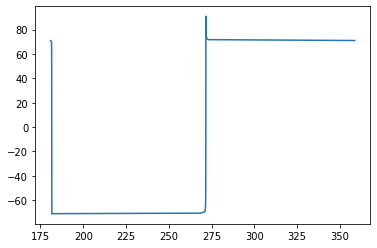

In [59]:
sorted_stresses = stresses.copy().sort_values('heading')

plt.plot(sorted_stresses.heading, sorted_stresses.stress)
spline = InterpolatedUnivariateSpline(sorted_stresses.heading, sorted_stresses.stress)
spx = np.linspace(180, 360, 360)
# plt.plot(spx, spline(spx))

In [60]:
stresses

lon    lat     stress     heading  headingCategory  deltaStress  time
0    21.45 -3.838  67.292556  181.537002            182.0    -0.405658     0
1    21.45 -3.838  66.866400  181.541671            182.0    -0.426156     1
2    21.45 -3.838  66.419877  181.545781            182.0    -0.446524     2
3    21.45 -3.838  65.953121  181.549428            182.0    -0.466756     3
4    21.45 -3.838  65.466276  181.552690            182.0    -0.486845     4
..     ...    ...        ...         ...              ...          ...   ...
355  21.45 -3.838  69.113492  181.498984            181.0    -0.301443   355
356  21.45 -3.838  68.790997  181.509492            182.0    -0.322495   356
357  21.45 -3.838  68.447548  181.518163            182.0    -0.343449   357
358  21.45 -3.838  68.083250  181.525444            182.0    -0.364298   358
359  21.45 -3.838  67.698214  181.531649            182.0    -0.385037   359

[360 rows x 7 columns]